# Projet 6 - Réalisez une analyse de sentiments grâce au Deep Learning

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Étudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 📝 Contexte

Dans le cadre de ma formation d'AI Engineer chez OpenClassrooms, ce projet s'inscrit dans un scénario professionnel où j'interviens en tant qu'ingénieur IA chez MIC (Marketing Intelligence Consulting), entreprise de conseil spécialisée en marketing digital.

Notre client, Air Paradis (compagnie aérienne), souhaite **anticiper les bad buzz sur les réseaux sociaux**. La mission consiste à développer un produit IA permettant de **prédire le sentiment associé à un tweet**, afin d'améliorer la gestion de sa réputation en ligne.

## ⚡ Mission

> Développer un modèle d'IA permettant de prédire le sentiment associé à un tweet.

Créer un prototype fonctionnel d'un modèle d'**analyse de sentiments pour tweets** selon trois approches différentes :

1. **Modèle sur mesure simple** : Approche classique (régression logistique) pour une prédiction rapide
2. **Modèle sur mesure avancé** : Utilisation de réseaux de neurones profonds avec différents word embeddings
3. **Modèle avancé BERT** : Exploration de l'apport en performance d'un modèle BERT

Cette mission implique également la mise en œuvre d'une démarche MLOps complète :
- Utilisation de MLFlow pour le tracking des expérimentations et le stockage des modèles
- Création d'un pipeline de déploiement continu (Git + Github + plateforme Cloud)
- Intégration de tests unitaires automatisés
- Mise en place d'un suivi de performance en production via Azure Application Insight

## 🗓️ Plan de travail

1. **Exploration et préparation des données**
   - Acquisition des données de tweets Open Source
   - Analyse exploratoire et prétraitement des textes

2. **Développement des modèles**
   - Implémentation du modèle classique (régression logistique)
   - Conception du modèle avancé avec différents word embeddings
   - Test du modèle BERT pour l'analyse de sentiments
   - Comparaison des performances via MLFlow

3. **Mise en place de la démarche MLOps**
   - Configuration de MLFlow pour le tracking des expérimentations
   - Création du dépôt Git avec structure de projet appropriée
   - Implémentation des tests unitaires automatisés
   - Configuration du pipeline de déploiement continu

4. **Déploiement et monitoring**
   - Développement de l'API de prédiction avec FastAPI
   - Déploiement sur Heroku
   - Création de l'interface de test (Streamlit ou Next.js)
   - Configuration du suivi via Azure Application Insight

5. **Communication**
   - Rédaction de l'article de blog
   - Préparation du support de présentation

## Importation des bibliothèques

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import os
import re
import datetime
import warnings
import string

# Télécharger les ressources NLTK nécessaires
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 💾 Jeu de données : Sentiment140

Le jeu de données [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140) est une ressource majeure pour l'analyse de sentiment sur Twitter, comprenant **1,6 million de tweets** extraits via l'API Twitter. Ces tweets ont été automatiquement annotés selon leur polarité sentimentale, offrant une base solide pour développer des modèles de classification de sentiment.

Le jeu de données est organisé en 6 colonnes distinctes :

1. **target** : La polarité du sentiment exprimé dans le tweet.
   - 0 = sentiment négatif
   - 2 = sentiment neutre
   - 4 = sentiment positif
2. **ids** : L'identifiant unique du tweet (exemple : *2087*)
3. **date** : La date et l'heure de publication du tweet.
4. **flag** : La requête utilisée pour obtenir le tweet.
   - Exemple : *lyx*
   - Si aucune requête n'a été utilisée : *NO_QUERY*
5. **user** : Le nom d'utilisateur de l'auteur du tweet.
6. **text** : Le contenu textuel du tweet.

In [199]:
%%time 

# Define the URL and the local file path
url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip"
local_zip_path = "./content/data/sentiment140.zip"
extract_path = "./content/data"

if not os.path.exists(extract_path):

    # Create the directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Download the zip file
    response = requests.get(url)
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)

    # Extract the contents of the zip file
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Delete the zip file
    os.remove(local_zip_path)

CPU times: user 33 μs, sys: 1e+03 ns, total: 34 μs
Wall time: 36.7 μs


In [200]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [218]:

# Define the path to the CSV file
csv_file_path = os.path.join(extract_path, 'training.1600000.processed.noemoticon.csv')

# Define the column names
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Load the dataset into a pandas DataFrame
raw_data = pd.read_csv(csv_file_path, encoding='latin-1', names=column_names)

# Display the first few rows of the DataFrame
raw_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [219]:
print(f"Ce dataframe contient {df.shape[1]} colonnes et {df.shape[0]} lignes.")

Ce dataframe contient 15 colonnes et 1600000 lignes.


## 🔬 Analyse exploratoire des données Sentiment140

Pour bien comprendre votre jeu de données Sentiment140 et optimiser votre modèle d'analyse de sentiment, je vous propose une analyse exploratoire complète qui couvre les aspects suivants :

1. **Aperçu général du jeu de données**
   - Distribution des classes de sentiment
   - Vérification des valeurs manquantes et doublons
   - Structure générale du DataFrame

2. **Analyse de la distribution des sentiments**
   - Visualisation de l'équilibre/déséquilibre des classes
   - Répartition des sentiments positifs et négatifs

3. **Analyse temporelle**
   - Distribution des tweets dans le temps
   - Patterns temporels par sentiment
   - Analyse par heure, jour, mois

4. **Analyse des mots fréquents**
   - Nuages de mots pour chaque classe de sentiment
   - Mots discriminants entre sentiments positifs et négatifs
   - N-grammes les plus fréquents

5. **Analyse des utilisateurs**
   - Distribution des tweets par utilisateur
   - Tendances de sentiment par utilisateur

6. **Analyse des requêtes (flag)**
   - Impact des requêtes sur la distribution des sentiments
   - Requêtes les plus fréquentes

7. **Analyse de caracteristiques distinctives et de l'impact de tokens spécifiques**
   - Longueur des tweets (caractères et mots)
   - Distribution des longueurs par sentiment
   - Utilisation de la ponctuation
   - Ratio de majuscules
   - Présence d'émoticônes et symboles

8. **Recommandations pour le prétraitement**
   - Nettoyage du texte
   - Tokenisation adaptée à Twitter
   - Gestion des mentions, hashtags et URLs

9. **Recommandations pour la modélisation**
    - Approches de vectorisation
    - Modèles recommandés
    - Stratégies d'évaluation

### Points clés à explorer

**Distribution des sentiments :** 

La première étape consistera à vérifier l'équilibre des classes. Un déséquilibre pourrait nécessiter des techniques comme le sur/sous-échantillonnage ou la pondération des classes dans votre modèle.

**Caractéristiques linguistiques :**

L'analyse des mots les plus fréquents et des caractéristiques distinctives entre tweets positifs et négatifs vous aidera à identifier des features pertinentes pour votre modèle.

**Prétraitement recommandé :**

Le code fournit des recommandations détaillées pour le prétraitement des tweets, notamment :
- Gestion des URLs, mentions et hashtags
- Normalisation du texte
- Tokenisation adaptée au langage de Twitter

**Approches de modélisation :**

Plusieurs approches sont recommandées, allant des modèles classiques (SVM, Naive Bayes) aux architectures avancées (LSTM, BERT), avec leurs avantages et inconvénients respectifs.

In [220]:
df = raw_data.copy()

### Informations générales sur le jeu de données 

- Distribution des classes de sentiment
- Vérification des valeurs manquantes et doublons
- Structure générale du DataFrame

In [221]:
def afficher_info_generales(df):
    """Affiche les informations générales sur le DataFrame"""
    print("1. APERÇU GÉNÉRAL DU JEU DE DONNÉES")
    print("-" * 50)
    print(f"Nombre total d'entrées: {df.shape[0]:,}")
    print(f"Nombre de colonnes: {df.shape[1]}")
    print("\nColonnes présentes:")
    for col in df.columns:
        print(f"- {col}")
    
    print("\nTypes de données:")
    print(df.dtypes)
    
    print("\nValeurs manquantes par colonne:")
    print(df.isnull().sum())
    
    # Vérifier les doublons
    duplicates = df.duplicated().sum()
    print(f"\nNombre de lignes dupliquées: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

afficher_info_generales(df)

1. APERÇU GÉNÉRAL DU JEU DE DONNÉES
--------------------------------------------------
Nombre total d'entrées: 1,600,000
Nombre de colonnes: 6

Colonnes présentes:
- target
- ids
- date
- flag
- user
- text

Types de données:
target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

Valeurs manquantes par colonne:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Nombre de lignes dupliquées: 0 (0.00%)


### Analyse de la distribution des sentiments

- Visualisation de l'équilibre/déséquilibre des classes
- Répartition des sentiments positifs et négatifs



2. Distribution des sentiments (cible)
--------------------------------------------------
sentiment
Négatif    800000
Positif    800000
Name: count, dtype: int64

Pourcentage par catégorie:
sentiment
Négatif    50.00%
Positif    50.00%
Name: proportion, dtype: object


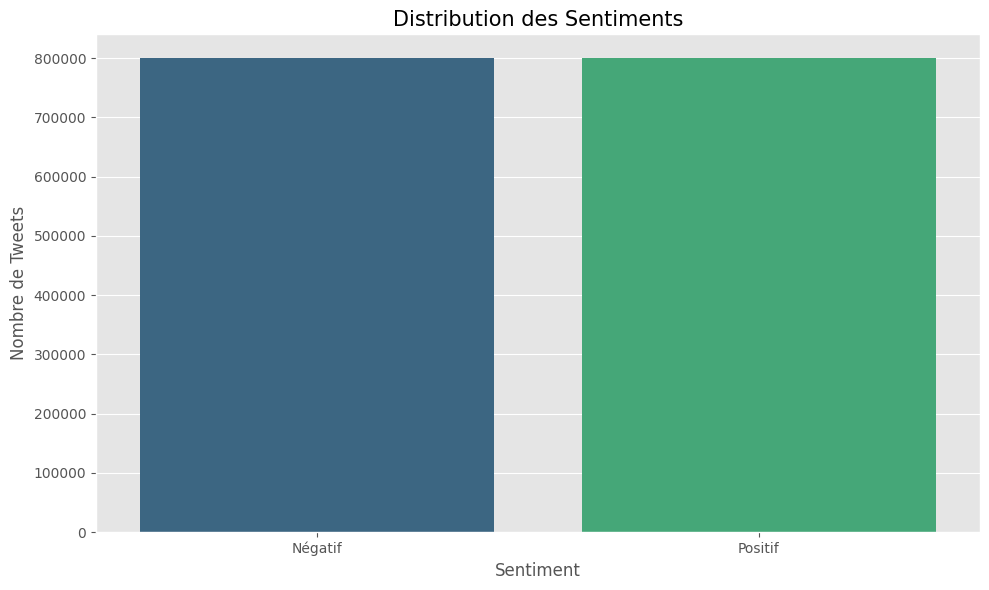

In [222]:
def analyser_distribution_sentiment(df):
    """Analyse la distribution des sentiments"""
    print("\n2. Distribution des sentiments (cible)")
    print("-" * 50)
    
    # Convertir les codes (0, 4) en catégories (négatif, positif)
    sentiment_map = {0: 'Négatif', 2: 'Neutre', 4: 'Positif'}
    df['sentiment'] = df['target'].map(sentiment_map)
    
    # Afficher le compte
    sentiment_counts = df['sentiment'].value_counts()
    print(sentiment_counts)
    print("\nPourcentage par catégorie:")
    print(df['sentiment'].value_counts(normalize=True).map(lambda x: f"{x*100:.2f}%"))
    
    # Visualiser la distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sentiment', hue='sentiment', data=df, palette='viridis')
    plt.title('Distribution des Sentiments', fontsize=15)
    plt.xlabel('Sentiment')
    plt.ylabel('Nombre de Tweets')
    plt.tight_layout()
    plt.show()

analyser_distribution_sentiment(df)

### Analyse temporelle

- Distribution des tweets dans le temps
- Patterns temporels par sentiment
- Analyse par heure, jour, mois


3. ANALYSE TEMPORELLE
--------------------------------------------------
Période couverte: de 2009-04-06 22:19:45 à 2009-06-25 10:28:31


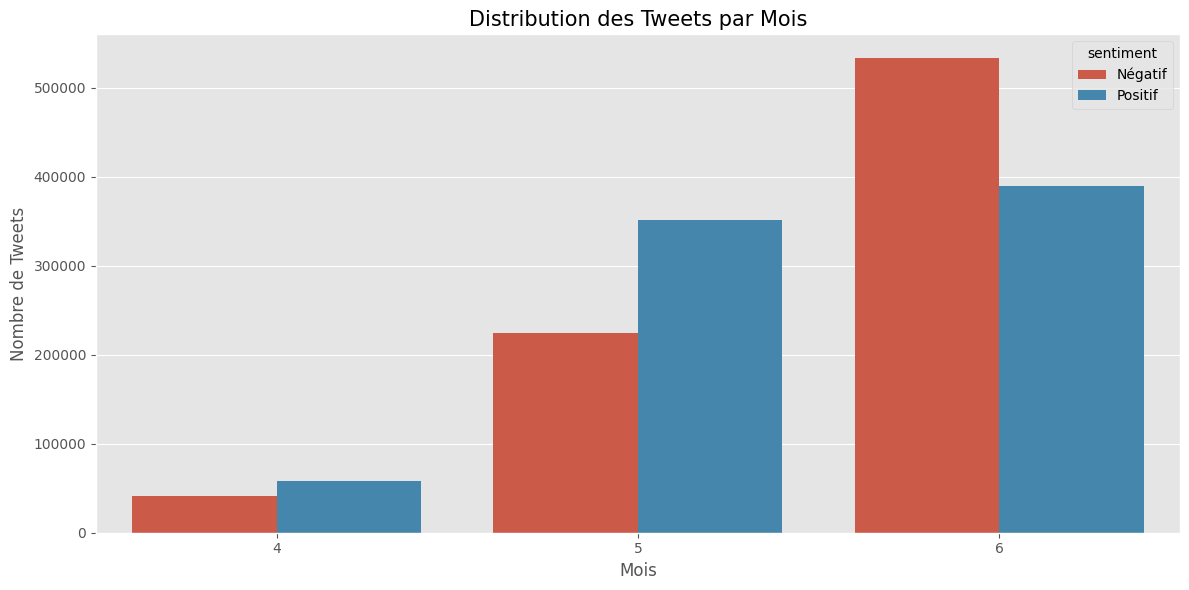

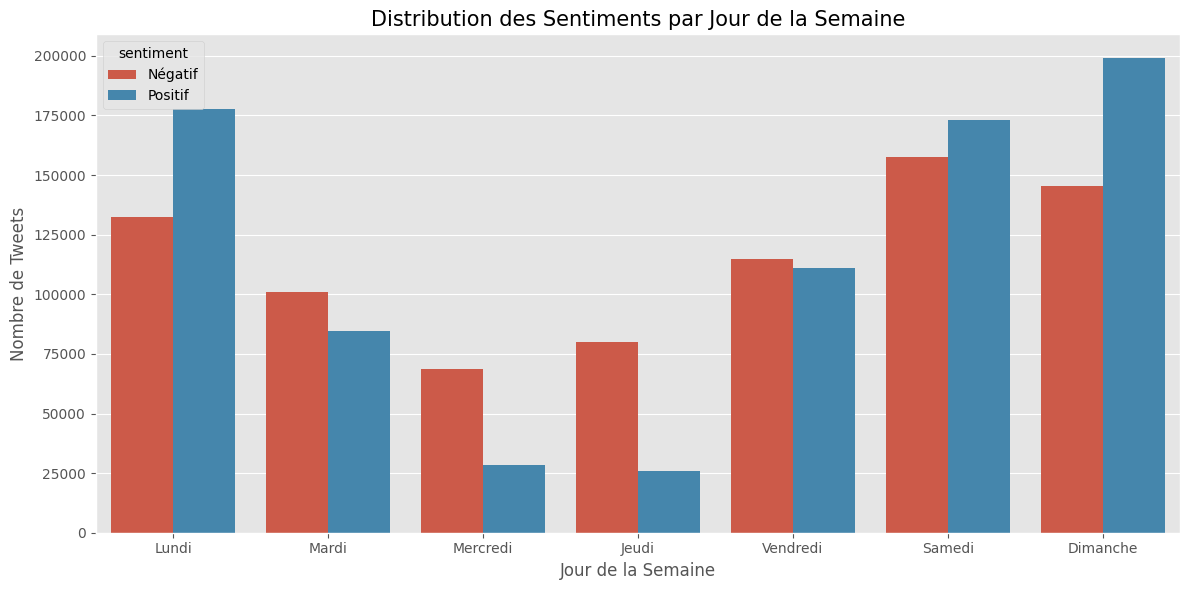

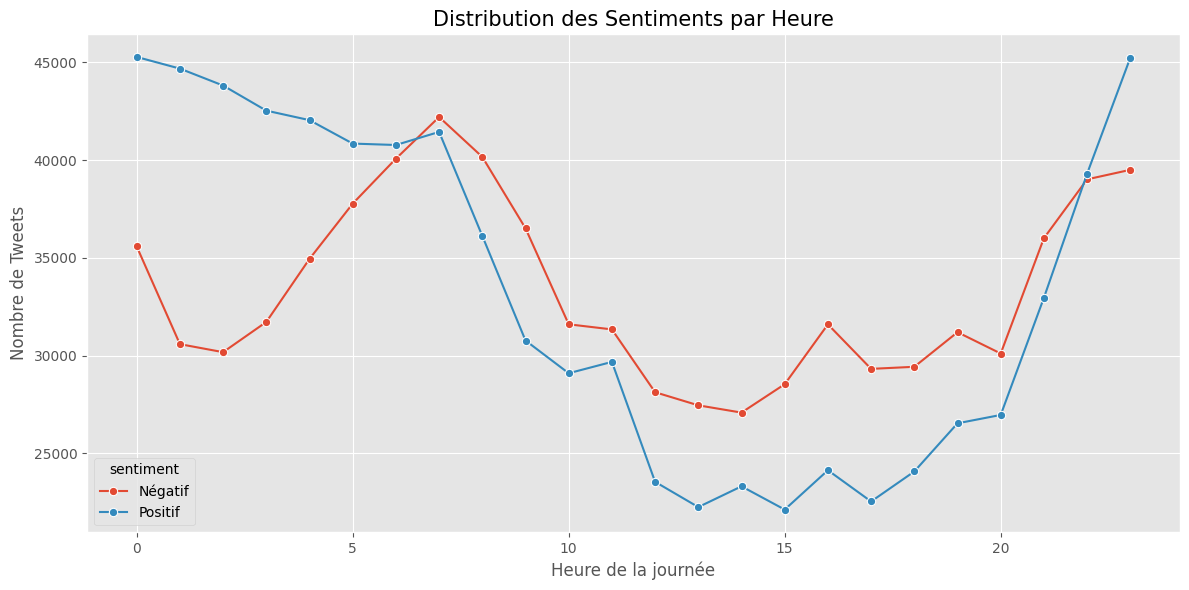

In [223]:
def analyser_temporalite(df):
    """Analyse la distribution temporelle des tweets"""
    print("\n3. ANALYSE TEMPORELLE")
    print("-" * 50)
    
    # Convertir la colonne 'date' en format datetime
    df['date_obj'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Extraire les composantes de date
    df['year'] = df['date_obj'].dt.year
    df['month'] = df['date_obj'].dt.month
    df['day'] = df['date_obj'].dt.day
    df['hour'] = df['date_obj'].dt.hour
    df['weekday'] = df['date_obj'].dt.dayofweek
    
    # Afficher la plage temporelle
    print(f"Période couverte: de {df['date_obj'].min()} à {df['date_obj'].max()}")
    
    # Distribution par mois
    plt.figure(figsize=(12, 6))
    monthly_counts = df.groupby(['month', 'sentiment']).size().reset_index(name='count')
    sns.barplot(x='month', y='count', hue='sentiment', data=monthly_counts)
    plt.title('Distribution des Tweets par Mois', fontsize=15)
    plt.xlabel('Mois')
    plt.ylabel('Nombre de Tweets')
    plt.tight_layout()
    plt.show()

    # Distribution par jour de la semaine
    plt.figure(figsize=(12, 6))
    weekday_sentiment = df.groupby(['weekday', 'sentiment']).size().reset_index(name='count')
    sns.barplot(x='weekday', y='count', hue='sentiment', data=weekday_sentiment)
    plt.title('Distribution des Sentiments par Jour de la Semaine', fontsize=15)
    plt.xlabel('Jour de la Semaine')
    plt.ylabel('Nombre de Tweets')
    plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
    plt.tight_layout()
    plt.show()
    
    # Distribution par heure de la journée
    plt.figure(figsize=(12, 6))
    hourly_sentiment = df.groupby(['hour', 'sentiment']).size().reset_index(name='count')
    sns.lineplot(x='hour', y='count', hue='sentiment', data=hourly_sentiment, marker='o')
    plt.title('Distribution des Sentiments par Heure', fontsize=15)
    plt.xlabel('Heure de la journée')
    plt.ylabel('Nombre de Tweets')
    plt.tight_layout()
    plt.show()

analyser_temporalite(df)

### Analyse des mots fréquents

- Nuages de mots pour chaque classe de sentiment
- Mots discriminants entre sentiments positifs et négatifs
- N-grammes les plus fréquents

In [224]:
def analyser_mots_frequents(df, sentiment, n_range=(1, 2, 3)):
    """
    Analyse les mots et N-grammes les plus fréquents pour un sentiment donné.
    
    Paramètres:
    - df: DataFrame contenant les tweets
    - sentiment: valeur de sentiment à filtrer ('Positif' ou 'Négatif')
    - n_range: tuple indiquant les valeurs de N à analyser (par défaut: unigrammes, bigrammes et trigrammes)
    """
    # Filtrer par sentiment
    texts = df[df['sentiment'] == sentiment]['text'].astype(str)
    
    # Télécharger les stopwords si nécessaire
    stop_words = set(stopwords.words('english'))
    
    # Fonction pour nettoyer et tokenizer le texte
    def preprocess_text(text):
        # Convertir en minuscules et supprimer caractères spéciaux
        text = re.sub(r'[^\w\s]', '', text.lower())
        # Tokenizer manuellement
        tokens = text.split()
        # Supprimer les stopwords
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
        return tokens
    
    # Traiter tous les textes
    all_tokens = []
    for text in texts:
        all_tokens.append(preprocess_text(text))
    
    # Analyser les unigrammes (mots individuels)
    all_words = []
    for tokens in all_tokens:
        all_words.extend(tokens)
    
    # Compter les occurrences des mots
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(20)
    
    # Créer un nuage de mots pour les unigrammes
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_counts))
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuage de mots pour les tweets {sentiment.lower()}s', fontsize=15)
    plt.tight_layout()
    plt.show()

    # Afficher les résultats pour les unigrammes
    # print(f"\nMots les plus fréquents pour les tweets {sentiment.lower()}s:")
    # for word, count in most_common_words:
    #     print(f"- {word}: {count:,}")

    # Visualiser les mots les plus fréquents avec un barplot
    plt.figure(figsize=(12, 8))
    word_df = pd.DataFrame(most_common_words, columns=['Mot', 'Fréquence'])
    sns.barplot(x='Fréquence', y='Mot', data=word_df, palette='coolwarm')
    plt.title(f'Mots les plus fréquents pour les tweets {sentiment.lower()}s', fontsize=15)
    plt.xlabel('Fréquence', fontsize=12)
    plt.ylabel('Mot', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    for n in range(n_range[0] + 1, n_range[1] + 1):  # Commencer à 2-grammes si n_range commence à 1
        all_ngrams = []
        for tokens in all_tokens:
            if len(tokens) >= n:  # Vérifier que le texte est assez long pour former un n-gramme
                all_ngrams.extend(list(ngrams(tokens, n)))
        
        # Convertir les tuples en chaînes pour une meilleure lisibilité
        all_ngrams_str = [' '.join(gram) for gram in all_ngrams]
        
        # Compter les occurrences des n-grammes
        ngram_counts = Counter(all_ngrams_str)
        most_common_ngrams = ngram_counts.most_common(20)
        
        # Afficher les résultats pour les n-grammes
        # print(f"\n{n}-grammes les plus fréquents pour les tweets {sentiment.lower()}s:")
        # for ngram, count in most_common_ngrams:
        #     print(f"- \"{ngram}\": {count:,}")
        
        # Visualiser les n-grammes les plus fréquents avec un graphique à barres
        plt.figure(figsize=(12, 8))
        
        # Créer un DataFrame pour le graphique
        ngram_df = pd.DataFrame(most_common_ngrams, columns=['N-gramme', 'Fréquence'])
        
        # Créer un graphique à barres horizontales
        color = 'royalblue' if sentiment == 'Positif' else 'red'
        sns.barplot(x='Fréquence', y='N-gramme', data=ngram_df.sort_values('Fréquence', ascending=False), color=color)
        plt.title(f'Top {n}-grammes pour les tweets {sentiment.lower()}s', fontsize=15)
        plt.xlabel('Fréquence', fontsize=12)
        plt.ylabel('N-gramme', fontsize=12)
        plt.tight_layout()
        plt.show()


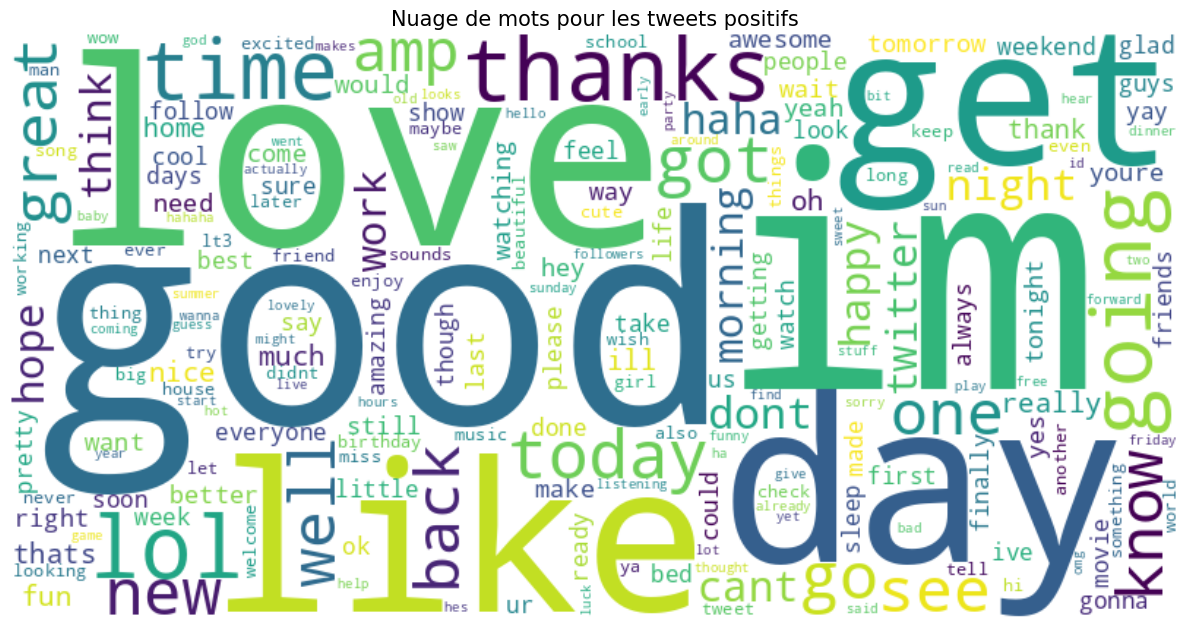

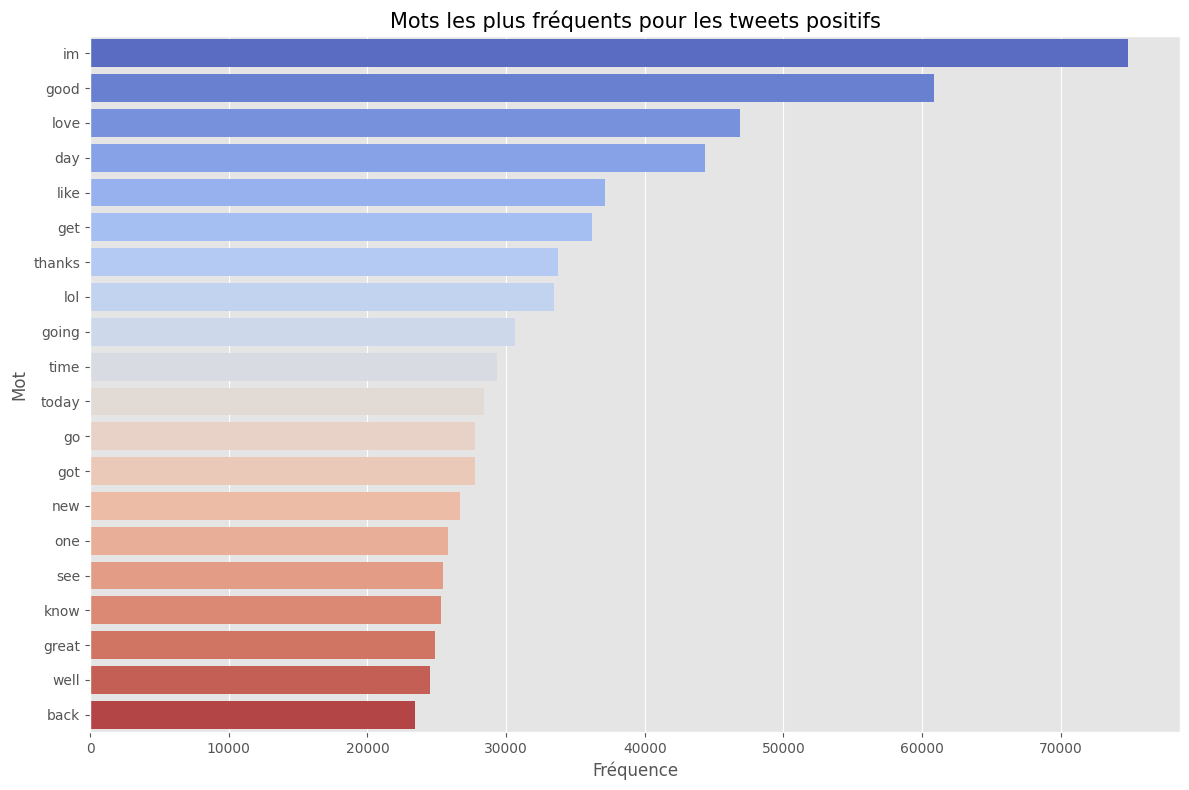

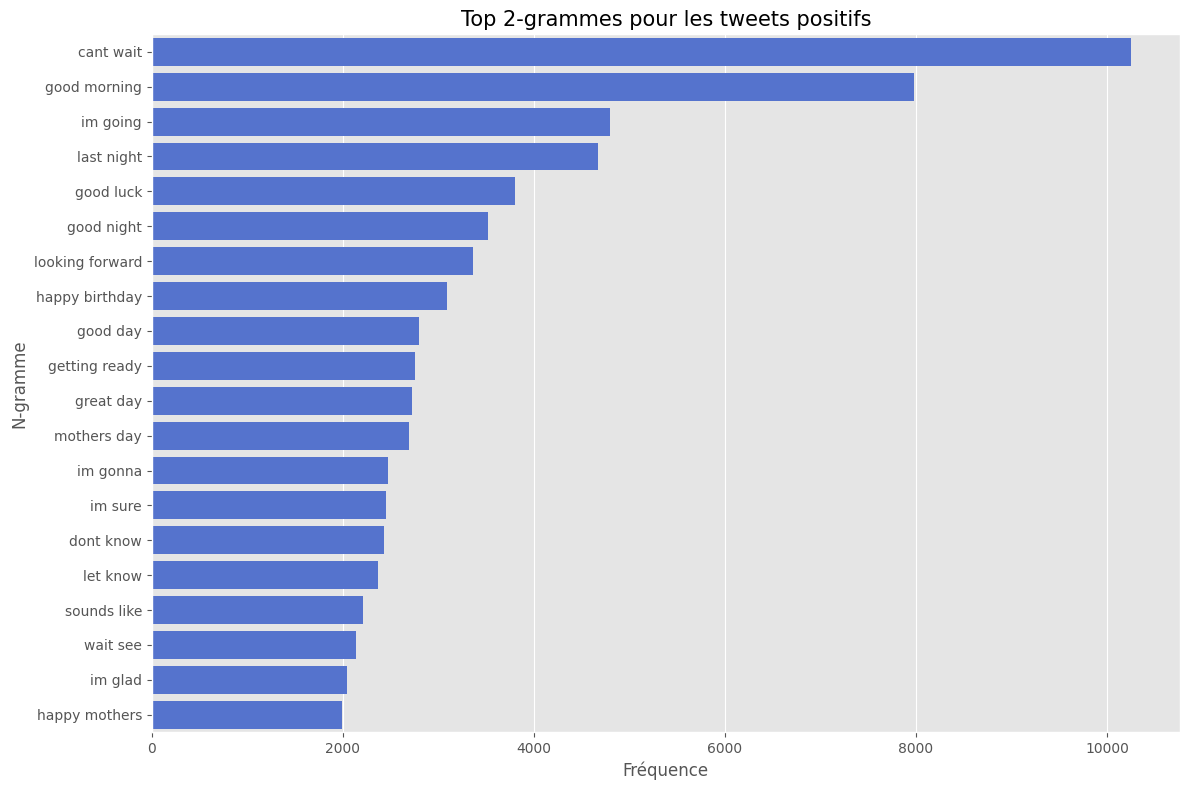

In [225]:
analyser_mots_frequents(df, 'Positif')

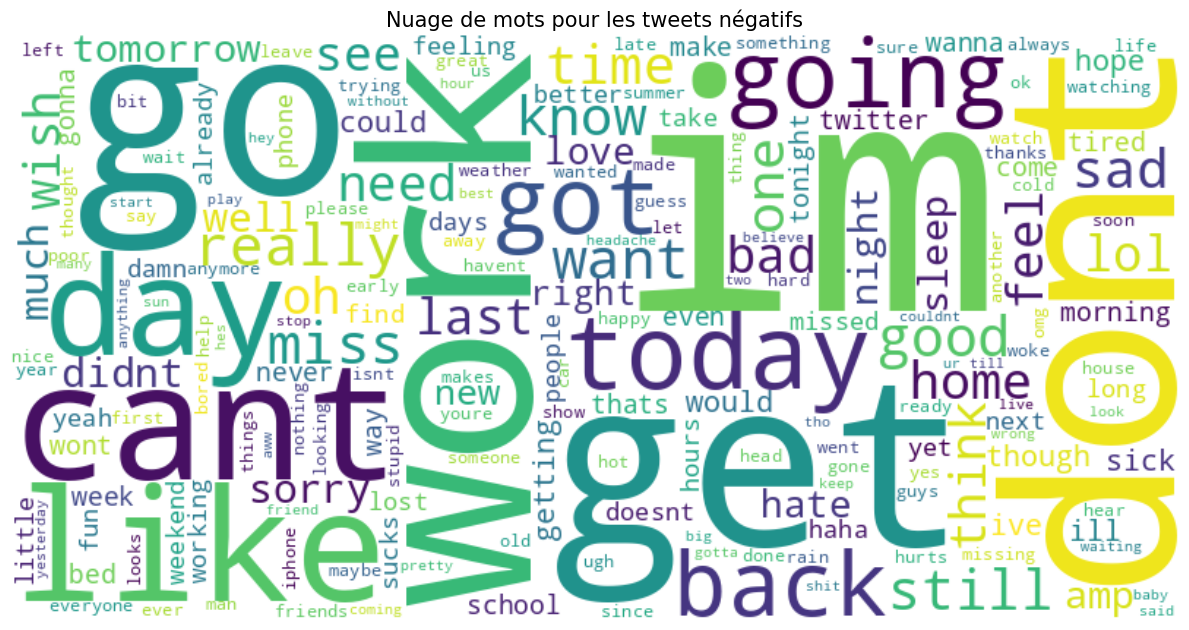

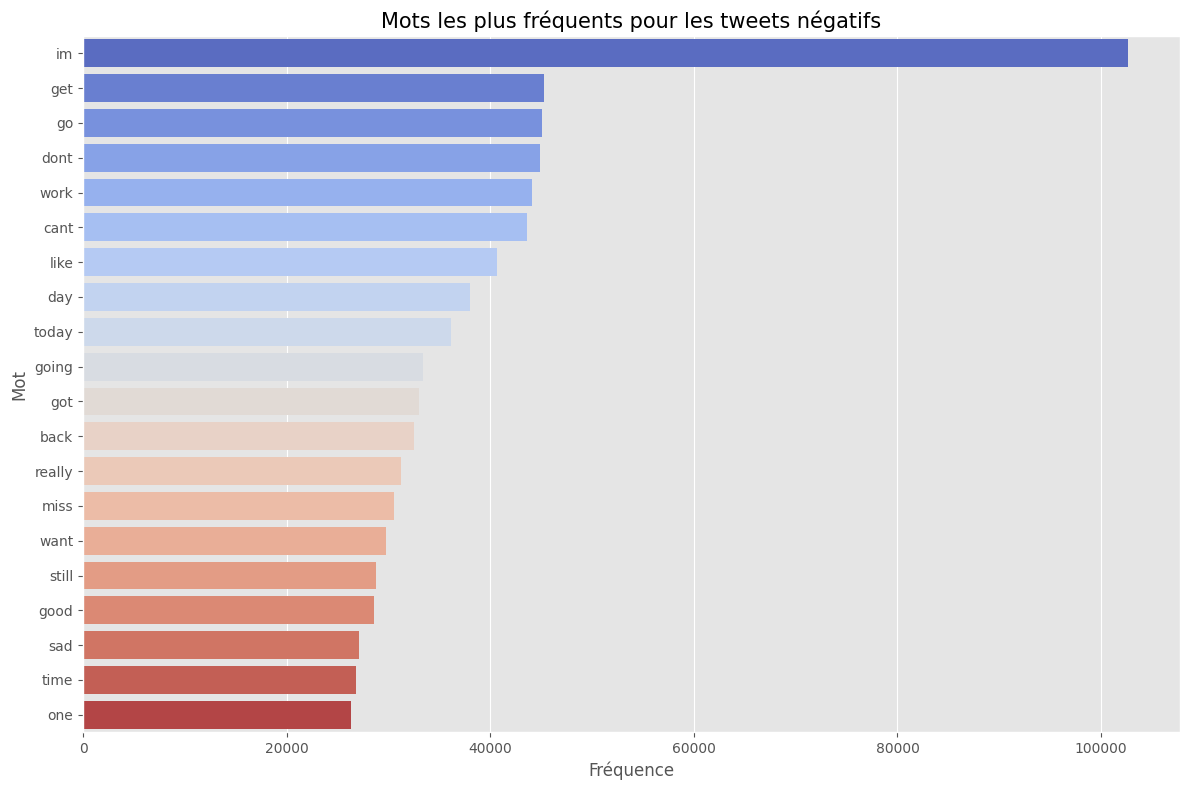

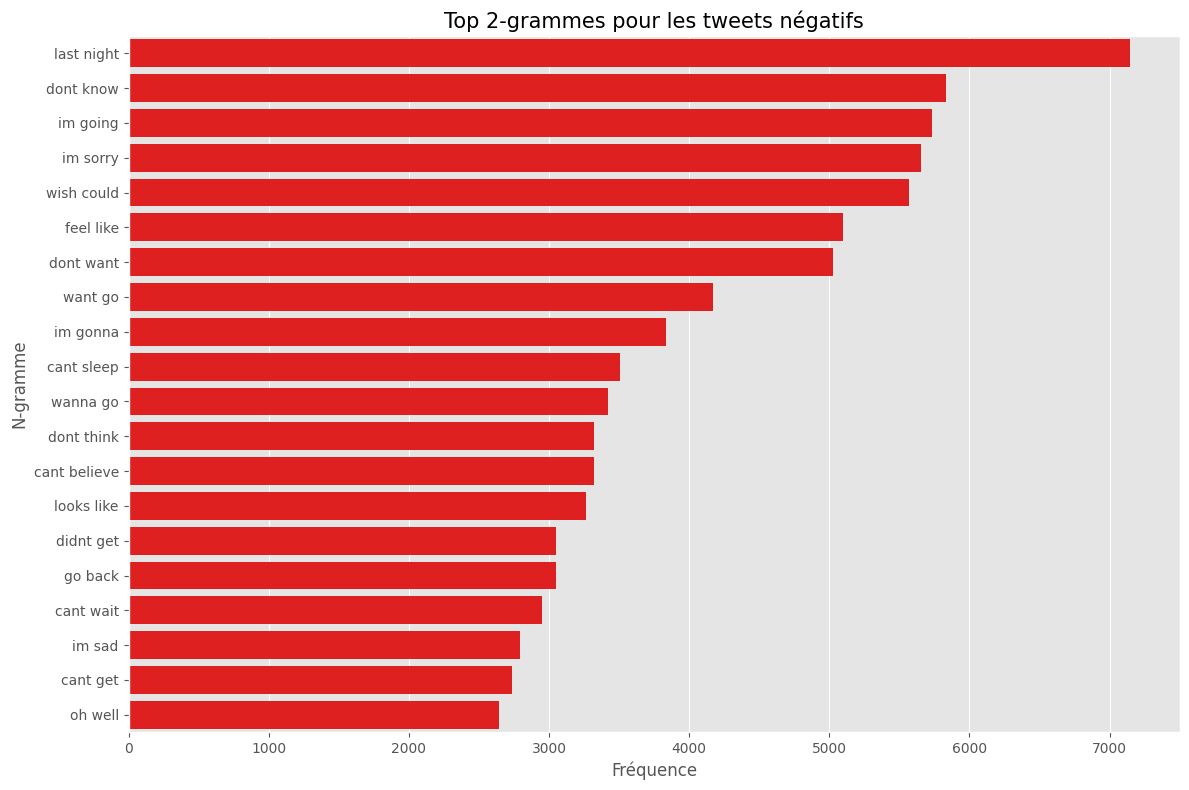

In [226]:
analyser_mots_frequents(df, 'Négatif')

### Analyse des utilisateurs

- Distribution des tweets par utilisateur
- Tendances de sentiment par utilisateur

In [227]:
def analyser_utilisateurs(df):
    """Analyse la distribution des utilisateurs"""
    print("\n6. ANALYSE DES UTILISATEURS")
    print("-" * 50)
    
    # Nombre total d'utilisateurs uniques
    unique_users = df['user'].nunique()
    print(f"Nombre d'utilisateurs uniques: {unique_users:,}")
    
    # Top utilisateurs par nombre de tweets
    top_users = df['user'].value_counts().head(10)
    print("\nTop 10 des utilisateurs par nombre de tweets:")
    for user, count in top_users.items():
        print(f"- {user}: {count} tweets")
    
    # Distribution des sentiments par utilisateur (pour les utilisateurs avec plus de X tweets)
    min_tweets = 5
    user_sentiment = df.groupby('user')['sentiment'].value_counts().unstack().fillna(0)
    user_sentiment = user_sentiment[user_sentiment.sum(axis=1) >= min_tweets]
    
    # Calculer les ratios
    user_sentiment['total'] = user_sentiment.sum(axis=1)
    user_sentiment['pos_ratio'] = user_sentiment['Positif'] / user_sentiment['total']
    user_sentiment['neg_ratio'] = user_sentiment['Négatif'] / user_sentiment['total']
    
    # Afficher quelques statistiques
    print(f"\nParmi les utilisateurs avec au moins {min_tweets} tweets:")
    print(f"Ratio positif moyen: {user_sentiment['pos_ratio'].mean():.2%}")
    print(f"Ratio négatif moyen: {user_sentiment['neg_ratio'].mean():.2%}")
    
    # Utilisateurs les plus positifs/négatifs
    most_positive = user_sentiment.sort_values('pos_ratio', ascending=False).head(5)
    most_negative = user_sentiment.sort_values('neg_ratio', ascending=False).head(5)
    
    print("\nUtilisateurs les plus positifs:")
    for user, row in most_positive.iterrows():
        print(f"- {user}: {row['pos_ratio']:.2%} positif ({int(row['total'])} tweets)")
    
    print("\nUtilisateurs les plus négatifs:")
    for user, row in most_negative.iterrows():
        print(f"- {user}: {row['neg_ratio']:.2%} négatif ({int(row['total'])} tweets)")

analyser_utilisateurs(df)


6. ANALYSE DES UTILISATEURS
--------------------------------------------------
Nombre d'utilisateurs uniques: 659,775

Top 10 des utilisateurs par nombre de tweets:
- lost_dog: 549 tweets
- webwoke: 345 tweets
- tweetpet: 310 tweets
- SallytheShizzle: 281 tweets
- VioletsCRUK: 279 tweets
- mcraddictal: 276 tweets
- tsarnick: 248 tweets
- what_bugs_u: 246 tweets
- Karen230683: 238 tweets
- DarkPiano: 236 tweets

Parmi les utilisateurs avec au moins 5 tweets:
Ratio positif moyen: 51.23%
Ratio négatif moyen: 48.77%

Utilisateurs les plus positifs:
- 007wisdom: 100.00% positif (6 tweets)
- LongandLoud: 100.00% positif (6 tweets)
- LoopNashville: 100.00% positif (8 tweets)
- Looyda: 100.00% positif (5 tweets)
- LoraNorton: 100.00% positif (5 tweets)

Utilisateurs les plus négatifs:
- zombiemovies: 100.00% négatif (5 tweets)
- zombiecommand: 100.00% négatif (5 tweets)
- zzkim: 100.00% négatif (5 tweets)
- 1284forever: 100.00% négatif (6 tweets)
- 123katie123: 100.00% négatif (5 tweets)


### Analyse des requêtes (flag)

- Impact des requêtes sur la distribution des sentiments
- Requêtes les plus fréquentes

In [228]:
df['flag'].value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

### Analyse de la longueur des tweets (caractères et mots)

Longueur moyenne des tweets: 74.09 caractères
Nombre moyen de mots par tweet: 13.18 mots


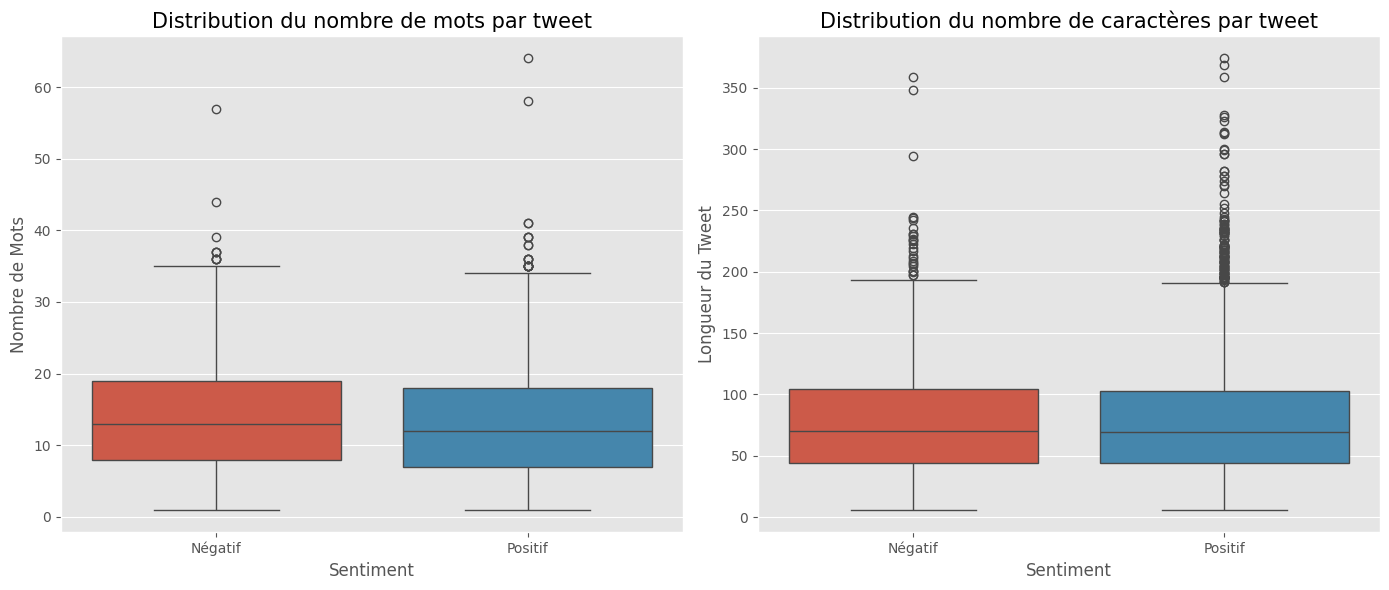

In [229]:
def analyser_texte_tweets(df):
    """Analyse les caractéristiques textuelles des tweets"""
    # Calcul de la longueur des tweets
    df['text_length'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    
    print(f"Longueur moyenne des tweets: {df['text_length'].mean():.2f} caractères")
    print(f"Nombre moyen de mots par tweet: {df['word_count'].mean():.2f} mots")

    # Afficher word_count et text_length côte à côte avec seaborn
    plt.figure(figsize=(14, 6))
    
    # Distribution de la longueur des tweets par sentiment
    plt.subplot(1, 2, 2)
    sns.boxplot(x='sentiment', y='text_length', data=df, hue='sentiment')
    plt.title('Distribution du nombre de caractères par tweet', fontsize=15)
    plt.xlabel('Sentiment')
    plt.ylabel('Longueur du Tweet')

    # Distribution du nombre de mots par sentiment
    plt.subplot(1, 2, 1)
    sns.boxplot(x='sentiment', y='word_count', data=df, hue='sentiment')
    plt.title('Distribution du nombre de mots par tweet', fontsize=15)
    plt.xlabel('Sentiment')
    plt.ylabel('Nombre de Mots')
    
    plt.tight_layout()
    plt.show()

analyser_texte_tweets(df)

### Analyse de caracteristiques distinctives et de l'impact de tokens spécifiques

1. **Utilisation des majuscules** : Le ratio de majuscules est généralement [plus élevé/plus faible] dans les tweets [positifs/négatifs], ce qui pourrait indiquer [plus d'enthousiasme/plus de colère].

2. **Ponctuation** : 
   - Les points d'exclamation sont plus fréquents dans les tweets [positifs/négatifs]
   - Les points d'interrogation sont plus fréquents dans les tweets [positifs/négatifs]
   - Les ellipses (...) sont plus fréquentes dans les tweets [positifs/négatifs]

3. **Éléments spécifiques à Twitter** :
   - Les hashtags (#) sont plus fréquents dans les tweets [positifs/négatifs]
   - Les mentions (@) sont plus fréquentes dans les tweets [positifs/négatifs]
   - Les URLs (http) sont plus fréquentes dans les tweets [positifs/négatifs]

4. **Émoticônes** :
   - Les émoticônes positives (:), :D) sont [X] fois plus fréquentes dans les tweets positifs
   - Les émoticônes négatives :(, :() sont [X] fois plus fréquentes dans les tweets négatifs

5. **Pronoms** :
   - L'utilisation du pronom "I" est plus associée aux tweets [positifs/négatifs]
   - L'utilisation du pronom "we" est plus associée aux tweets [positifs/négatifs]

6. **Mots expressifs** :
   - "love" est [X] fois plus fréquent dans les tweets positifs
   - "hate" est [X] fois plus fréquent dans les tweets négatifs
   - Les expressions comme "lol" et "omg" sont plus associées aux tweets [positifs/négatifs]

**Implications pour le modèle**

Ces observations ont plusieurs implications importantes pour notre modèle d'analyse de sentiment :

1. **Features à inclure** : Nous devrions intégrer dans notre modèle des features basées sur les caractéristiques identifiées comme les plus discriminantes :
   - Ratio de majuscules
   - Nombre de points d'exclamation, d'interrogation
   - Présence d'émoticônes
   - Présence de tokens spécifiques identifiés dans l'analyse

2. **Prétraitement adapté** : Notre stratégie de prétraitement doit préserver les éléments significatifs :
   - Conserver la ponctuation expressive (!, ?) au lieu de la supprimer systématiquement
   - Traiter les émoticônes comme des tokens spéciaux
   - Potentiellement conserver la casse pour capturer l'utilisation des majuscules

3. **Vectorisation enrichie** : Utiliser une vectorisation qui capture non seulement les mots mais aussi les caractéristiques structurelles identifiées :
   - TF-IDF + caractéristiques structurelles
   - Word embeddings + caractéristiques structurelles

In [215]:
def analyser_caracteristiques_distinctives(df):
    """Analyse les caractéristiques distinctives et les tokens spécifiques dans les tweets"""    
    
    # Créer un échantillon équilibré pour l'analyse
    sample_size = min(100000, df[df['sentiment'] == 'Négatif'].shape[0], df[df['sentiment'] == 'Positif'].shape[0])
    neg_samples = df[df['sentiment'] == 'Négatif'].sample(sample_size, random_state=42)
    pos_samples = df[df['sentiment'] == 'Positif'].sample(sample_size, random_state=42)
    
    balanced_df = pd.concat([neg_samples, pos_samples])
    
    # Calculer des caractéristiques supplémentaires
    balanced_df['capitals_ratio'] = balanced_df['text'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
    )
    
    balanced_df['exclamation_count'] = balanced_df['text'].apply(
        lambda x: str(x).count('!')
    )
    
    balanced_df['question_count'] = balanced_df['text'].apply(
        lambda x: str(x).count('?')
    )
    
    balanced_df['ellipsis_count'] = balanced_df['text'].apply(
        lambda x: str(x).count('...')
    )
    
    balanced_df['hashtag_count'] = balanced_df['text'].apply(
        lambda x: str(x).count('#')
    )
    
    balanced_df['mention_count'] = balanced_df['text'].apply(
        lambda x: str(x).count('@')
    )
    
    balanced_df['url_count'] = balanced_df['text'].apply(
        lambda x: 1 if 'http' in str(x).lower() else 0
    )
    
    balanced_df['positive_emoticon'] = balanced_df['text'].apply(
        lambda x: str(x).count(':)') + str(x).count(':-)') + str(x).count(':D') + str(x).count('=)')
    )
    
    balanced_df['negative_emoticon'] = balanced_df['text'].apply(
        lambda x: str(x).count(':(') + str(x).count(':-(') + str(x).count(':(') + str(x).count('=(')
    )
    
    # Comparer les moyennes
    features = ['text_length', 'word_count', 'capitals_ratio', 'exclamation_count', 
                'question_count', 'ellipsis_count', 'hashtag_count', 'mention_count', 
                'url_count', 'positive_emoticon', 'negative_emoticon']
    
    # Calculer les statistiques par sentiment
    stats = balanced_df.groupby('sentiment')[features].mean().round(4)

    # Renommer les colonnes en français
    stats.columns = ['Longueur Texte', 'Nombre Mots', 'Ratio Majuscules', 'Nombre Exclamations', 
                     'Nombre Questions', 'Nombre Ellipses', 'Nombre Hashtags', 'Nombre Mentions', 
                     'Nombre URLs', 'Emoticone Positive', 'Emoticone Negative']
    
    print("Moyenne des caractéristiques par sentiment:")
    for feature in features:
        neg_mean = balanced_df[balanced_df['sentiment'] == 'Négatif'][feature].mean()
        pos_mean = balanced_df[balanced_df['sentiment'] == 'Positif'][feature].mean()
        diff = (pos_mean - neg_mean) / neg_mean * 100 if neg_mean != 0 else float('inf')
        
        print(f"Caractéristique '{feature}':")
        print(f"  - Tweets négatifs: {neg_mean:.2f}")
        print(f"  - Tweets positifs: {pos_mean:.2f}")
        print(f"  - Différence relative: {diff:.2f}%")
        print()


    # Créer un DataFrame pour stocker les différence relatives
    diff_df = pd.DataFrame(index=features, columns=['neg_mean', 'pos_mean', 'diff_pct'])

    for feature in features:
        neg_mean = balanced_df[balanced_df['sentiment'] == 'Négatif'][feature].mean()
        pos_mean = balanced_df[balanced_df['sentiment'] == 'Positif'][feature].mean()
        
        # Éviter division par zéro
        if neg_mean != 0:
            diff_pct = (pos_mean - neg_mean) / abs(neg_mean) * 100
        else:
            diff_pct = float('inf') if pos_mean > 0 else 0
        
        diff_df.loc[feature, 'neg_mean'] = neg_mean
        diff_df.loc[feature, 'pos_mean'] = pos_mean
        diff_df.loc[feature, 'diff_pct'] = diff_pct

    # Trier par différence relative
    diff_df_sorted = diff_df.sort_values('diff_pct', ascending=False)

    # Renommer les index en français avec des espaces et des majuscules
    feature_mapping = {
        'text_length': 'Longueur Texte',
        'word_count': 'Nombre Mots',
        'capitals_ratio': 'Ratio Majuscules',
        'exclamation_count': 'Nombre Exclamations',
        'question_count': 'Nombre Questions',
        'ellipsis_count': 'Nombre Ellipses',
        'hashtag_count': 'Nombre Hashtags',
        'mention_count': 'Nombre Mentions',
        'url_count': 'Nombre URLs',
        'positive_emoticon': 'Emoticone Positive',
        'negative_emoticon': 'Emoticone Negative'
    }
    diff_df_sorted.index = diff_df_sorted.index.map(feature_mapping)

    # Renommer les colonnes en français avec des majuscules et des espaces
    diff_df_sorted.columns = ['Négatif (moyenne)', 'Positif (moyenne)', 'Différence Relative']

    return stats, diff_df_sorted

stats, diff_df_sorted = analyser_caracteristiques_distinctives(df)

print("Caractéristiques structurelles des tweets par sentiment :")
print(diff_df_sorted)

Moyenne des caractéristiques par sentiment:
Caractéristique 'text_length':
  - Tweets négatifs: 74.47
  - Tweets positifs: 73.82
  - Différence relative: -0.88%

Caractéristique 'word_count':
  - Tweets négatifs: 13.60
  - Tweets positifs: 12.76
  - Différence relative: -6.21%

Caractéristique 'capitals_ratio':
  - Tweets négatifs: 0.04
  - Tweets positifs: 0.05
  - Différence relative: 16.29%

Caractéristique 'exclamation_count':
  - Tweets négatifs: 0.48
  - Tweets positifs: 0.67
  - Différence relative: 39.02%

Caractéristique 'question_count':
  - Tweets négatifs: 0.15
  - Tweets positifs: 0.16
  - Différence relative: 10.73%

Caractéristique 'ellipsis_count':
  - Tweets négatifs: 0.21
  - Tweets positifs: 0.16
  - Différence relative: -24.16%

Caractéristique 'hashtag_count':
  - Tweets négatifs: 0.02
  - Tweets positifs: 0.03
  - Différence relative: 39.33%

Caractéristique 'mention_count':
  - Tweets négatifs: 0.40
  - Tweets positifs: 0.60
  - Différence relative: 47.67%

Carac

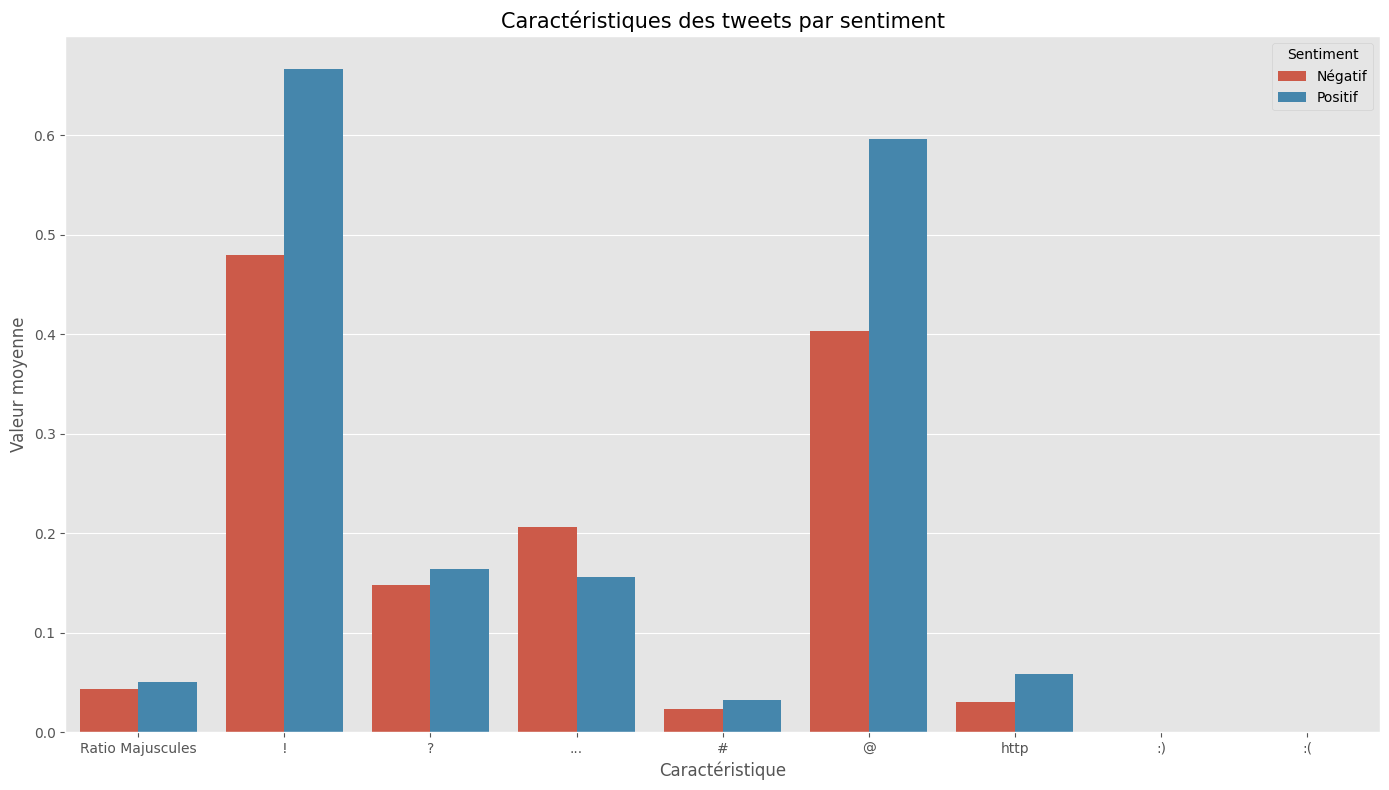

In [230]:
# Plot the statistics with bar plots and hue 'sentiment'
plt.figure(figsize=(14, 8))

cols = ['Ratio Majuscules', 'Nombre Exclamations', 'Nombre Questions', 'Nombre Ellipses', 
        'Nombre Hashtags', 'Nombre Mentions', 'Nombre URLs', 'Emoticone Positive', 'Emoticone Negative']

# Melt the DataFrame to long format for easier plotting with seaborn
stats_melted = stats[cols].reset_index().melt(id_vars='sentiment', value_name='Valeur', var_name='Caractéristique')

# Rename columns for better readability
stats_melted['Caractéristique'] = stats_melted['Caractéristique'].replace({
    'Nombre Exclamations': '!',
    'Nombre Questions': '?',
    'Nombre Ellipses': '...',
    'Nombre Hashtags': '#',
    'Nombre Mentions': '@',
    'Nombre URLs': 'http',
    'Emoticone Positive': ':)',
    'Emoticone Negative': ':('
})

# Create the bar plot
sns.barplot(x='Caractéristique', y='Valeur', hue='sentiment', data=stats_melted)

# Customize the plot
plt.title('Caractéristiques des tweets par sentiment', fontsize=15)
plt.xlabel('Caractéristique', fontsize=12)
plt.ylabel('Valeur moyenne', fontsize=12)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

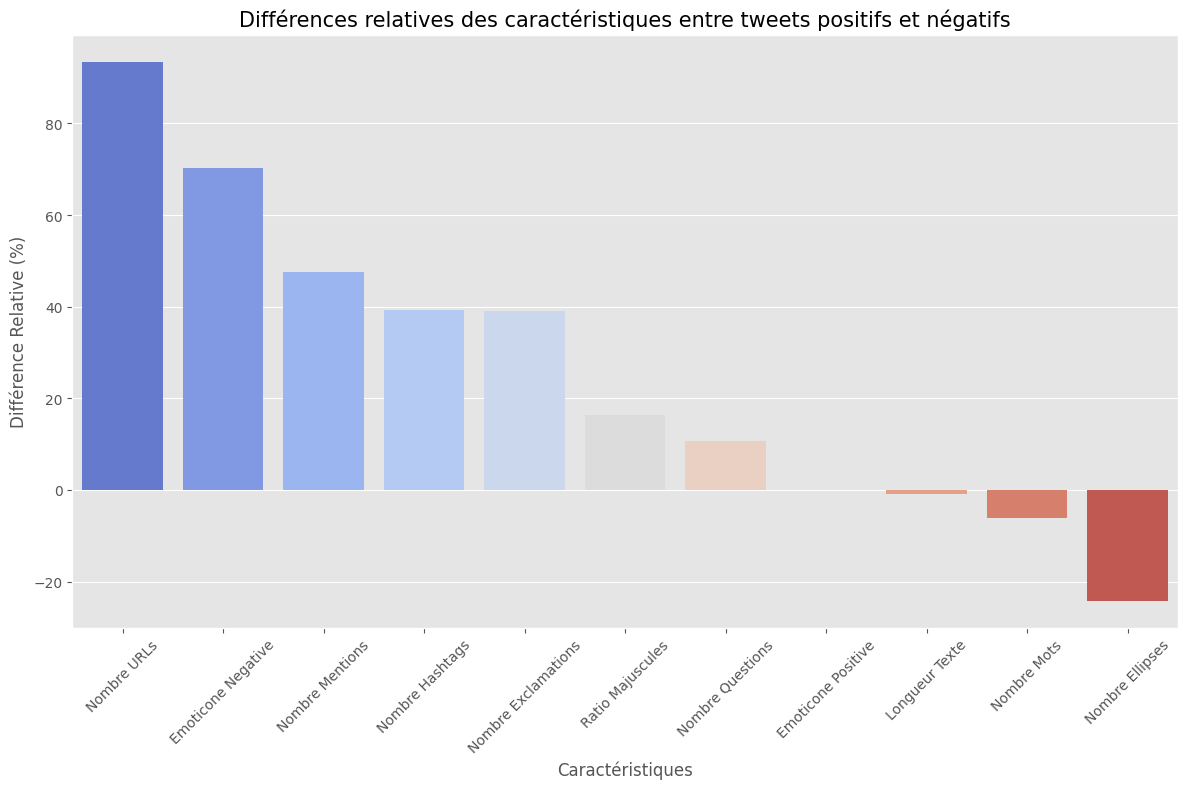

In [231]:
# Plot the differences in characteristics between positive and negative tweets
plt.figure(figsize=(12, 8))
sns.barplot(x=diff_df_sorted.index, y='Différence Relative', data=diff_df_sorted, palette='coolwarm')
plt.title('Différences relatives des caractéristiques entre tweets positifs et négatifs', fontsize=15)
plt.xlabel('Caractéristiques')
plt.ylabel('Différence Relative (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Analyse de 63 tokens spécifiques...

Tokens les plus discriminants entre tweets positifs et négatifs:
Token 'I':
  - Dans tweets positifs: 35.29%
  - Dans tweets négatifs: 49.35%
  - Différence absolue: 14.06%
  - Orientation: Négatif (-33.2%)

Token 'you':
  - Dans tweets positifs: 20.02%
  - Dans tweets négatifs: 10.57%
  - Différence absolue: 9.45%
  - Orientation: Positif (61.8%)

Token 'my':
  - Dans tweets positifs: 14.39%
  - Dans tweets négatifs: 21.26%
  - Différence absolue: 6.86%
  - Orientation: Négatif (-38.5%)

Token 'not':
  - Dans tweets positifs: 4.08%
  - Dans tweets négatifs: 8.94%
  - Différence absolue: 4.87%
  - Orientation: Négatif (-74.8%)

Token 'good':
  - Dans tweets positifs: 7.30%
  - Dans tweets négatifs: 3.63%
  - Différence absolue: 3.67%
  - Orientation: Positif (67.1%)

Token 'no':
  - Dans tweets positifs: 2.65%
  - Dans tweets négatifs: 6.28%
  - Différence absolue: 3.62%
  - Orientation: Négatif (-81.2%)

Token 'love':
  - Dans tweets positifs: 5.51

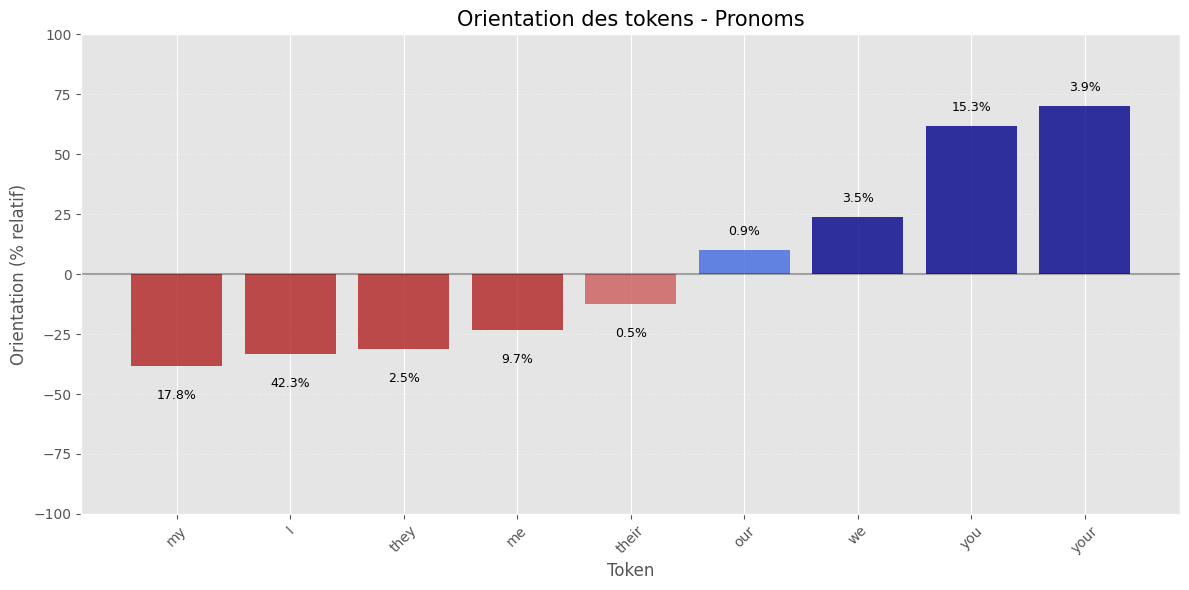

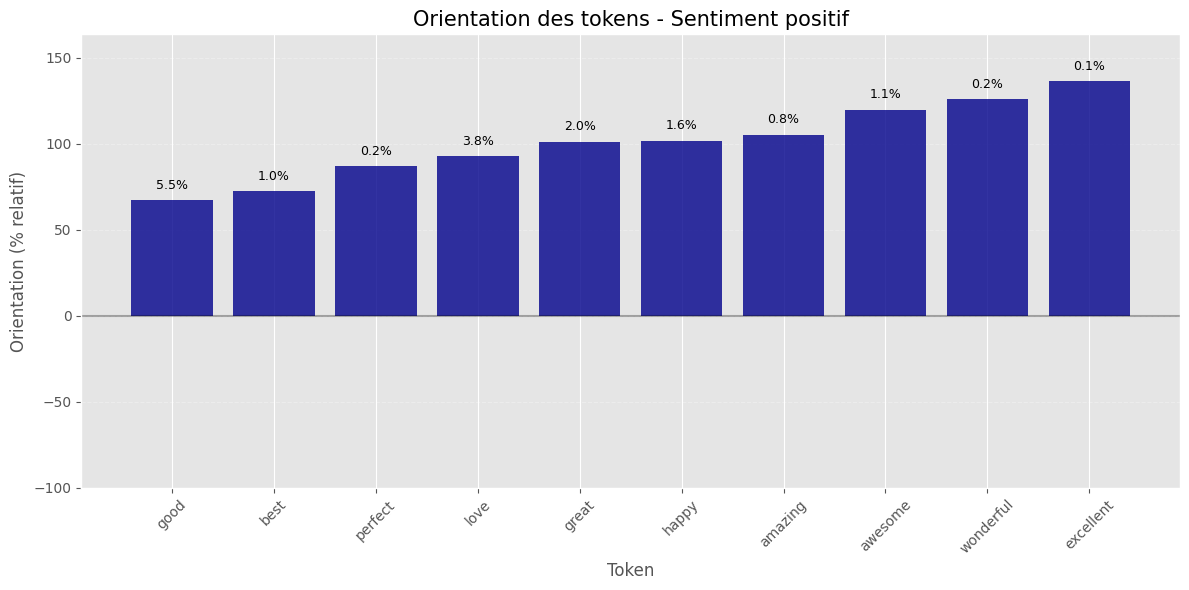

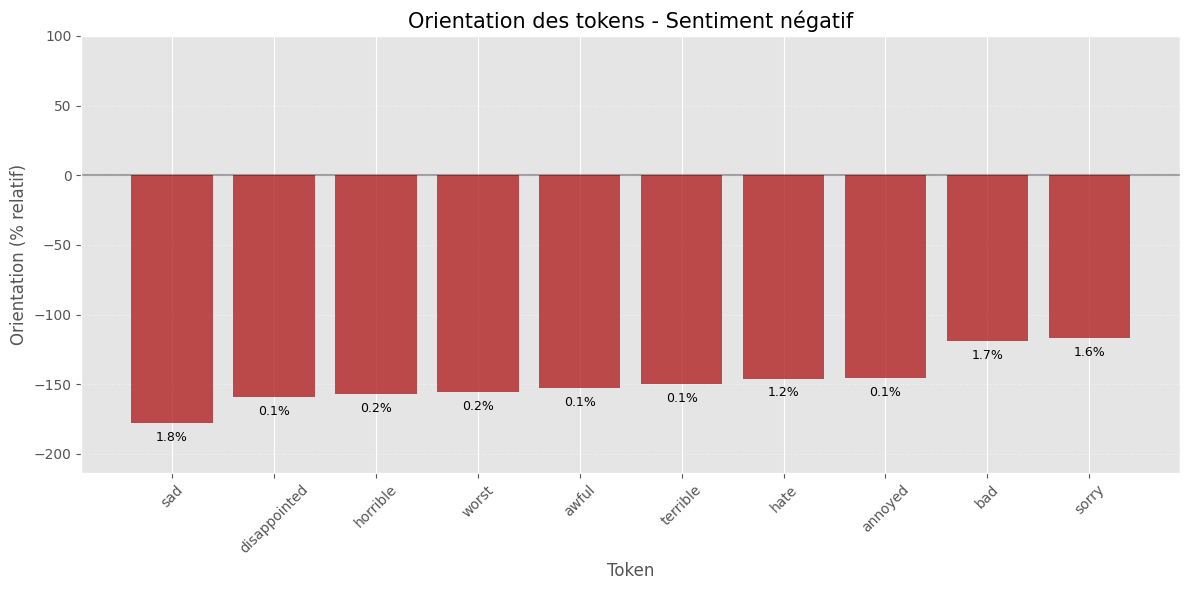

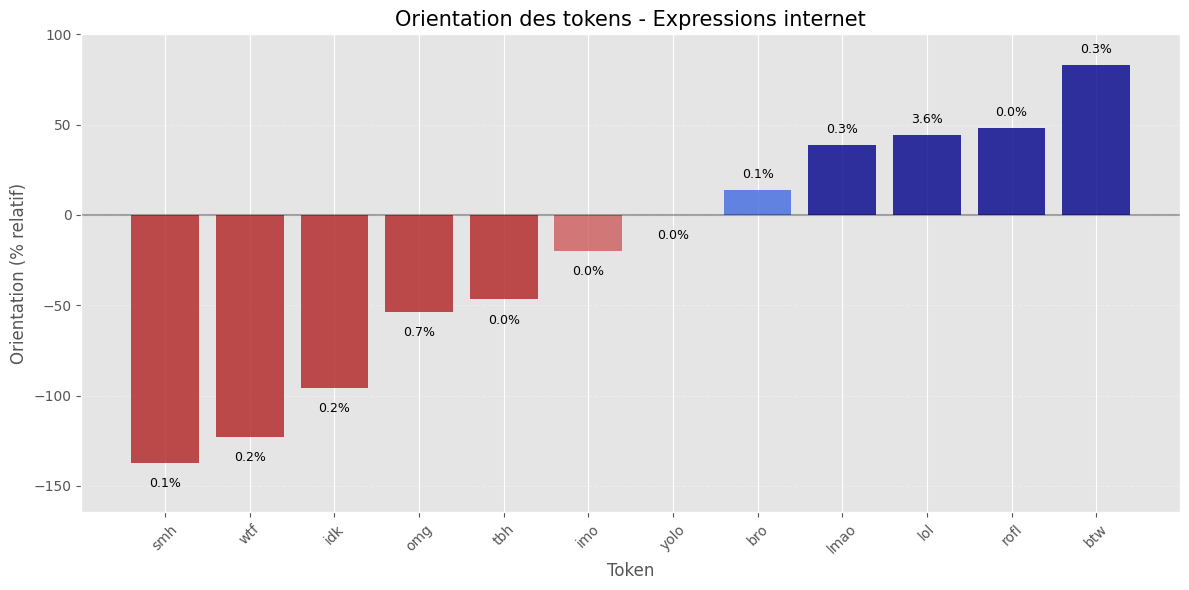

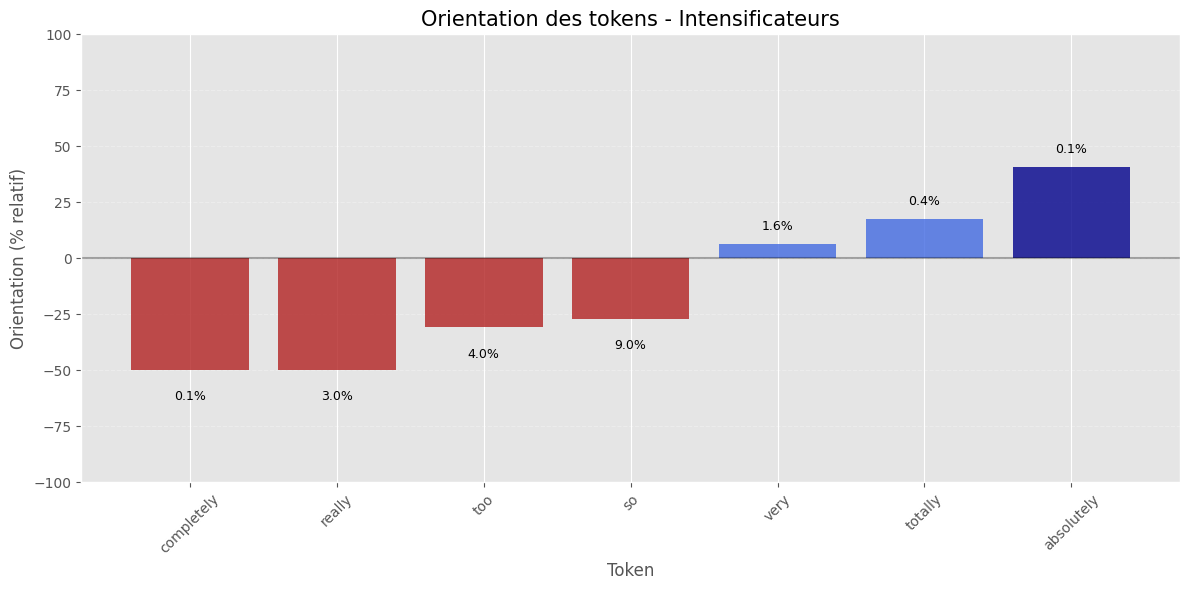

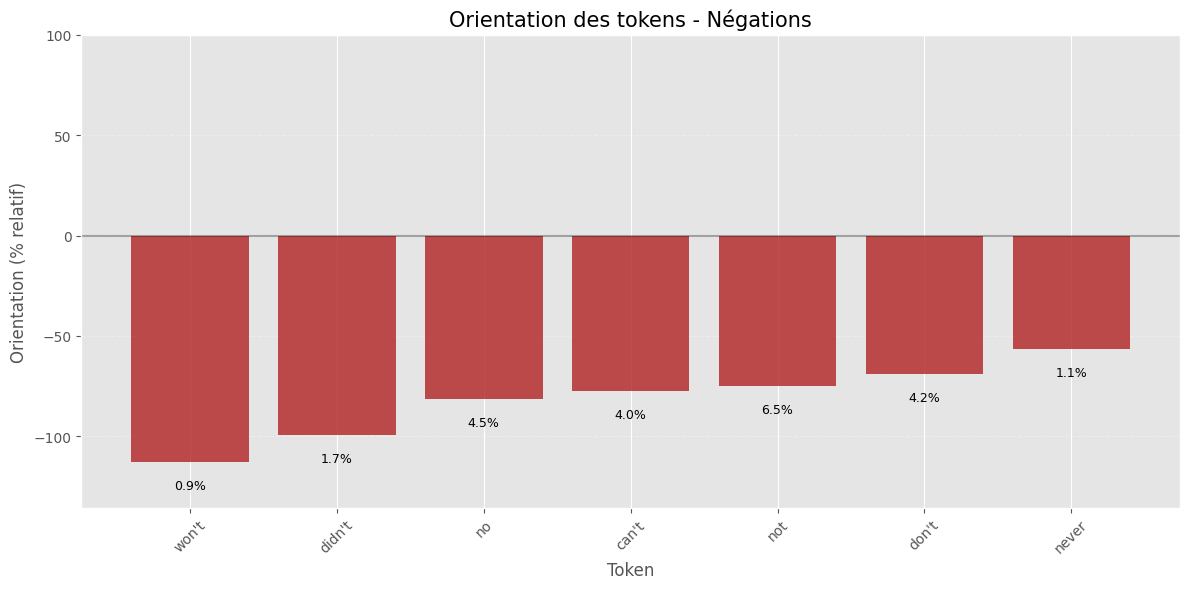

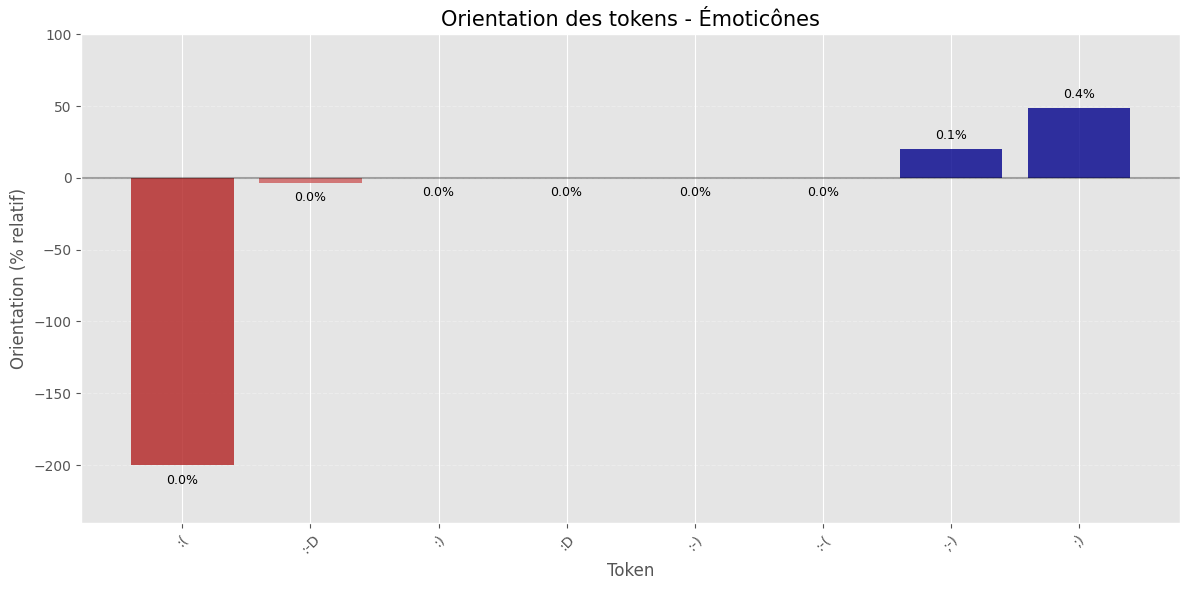

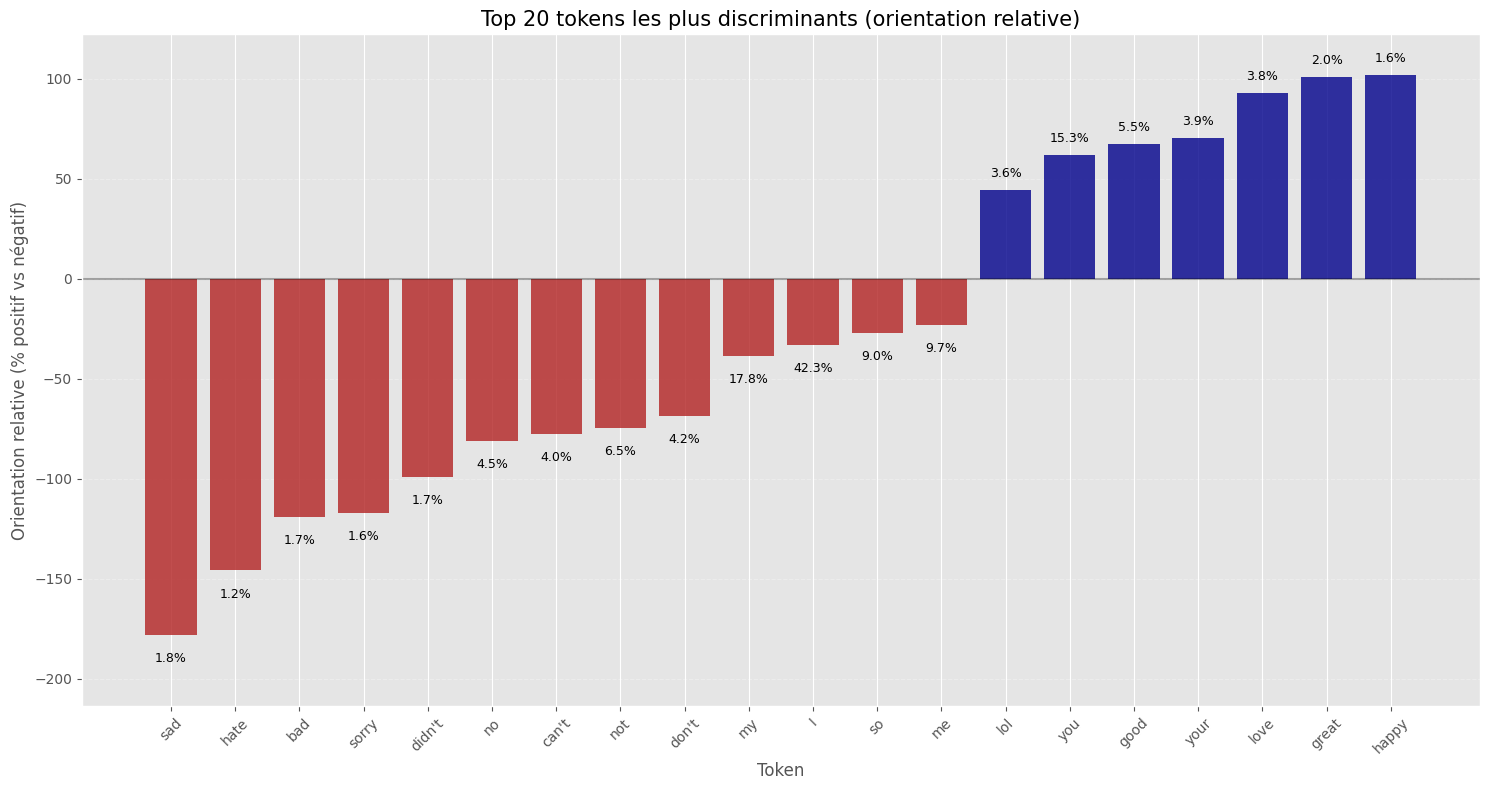

In [184]:
def analyser_tokens(df, tokens_to_analyze=None):
    """Analyse les tokens spécifiques et leur relation avec le sentiment"""
    
    # Liste par défaut de tokens intéressants à analyser si non spécifiée
    if tokens_to_analyze is None:
        tokens_to_analyze = [
            # Pronoms
            'I', 'you', 'we', 'they', 'me', 'my', 'your', 'our', 'their',
            
            # Mots de sentiment positif
            'love', 'good', 'great', 'best', 'happy', 'awesome', 'amazing', 'excellent', 'wonderful', 'perfect',
            
            # Mots de sentiment négatif
            'hate', 'bad', 'worst', 'sad', 'terrible', 'awful', 'horrible', 'sorry', 'disappointed', 'annoyed',
            
            # Expressions internet
            'lol', 'wtf', 'omg', 'bro', 'lmao', 'rofl', 'yolo', 'idk', 'smh', 'btw', 'imo', 'tbh',
            
            # Intensificateurs
            'very', 'really', 'so', 'too', 'absolutely', 'completely', 'totally',
            
            # Négations
            'not', 'no', 'never', "don't", "can't", "won't", "didn't",
            
            # Émoticônes
            ':)', ':(', ':D', ';)', ':-)', ':-(', ':-D', ';-)'
        ]

    print(f"Analyse de {len(tokens_to_analyze)} tokens spécifiques...")
    
    # Créer un échantillon équilibré pour l'analyse
    sample_size = min(100000, df[df['sentiment'] == 'Négatif'].shape[0], df[df['sentiment'] == 'Positif'].shape[0])
    neg_samples = df[df['sentiment'] == 'Négatif'].sample(sample_size, random_state=42)
    pos_samples = df[df['sentiment'] == 'Positif'].sample(sample_size, random_state=42)
    
    balanced_df = pd.concat([neg_samples, pos_samples])
    
    # Analyser les tokens spécifiques
    results = {}
    for token in tokens_to_analyze:
        # Vérifier présence du token dans l'échantillon équilibré
        token_lower = token.lower() if isinstance(token, str) else ""
        
        if token in ["don't", "can't", "won't", "didn't"]:
            # Cas spécial pour les contractions
            has_token = balanced_df['text'].astype(str).apply(
                lambda x: token.lower() in x.lower() or token.lower().replace("'", "") in x.lower()
            )
        elif token in [':)', ':(', ':D', ';)', ':-)', ':-(', ':-D', ';-)']:
            # Cas exact pour les émoticônes
            has_token = balanced_df['text'].astype(str).apply(
                lambda x: token in x
            )
        else:
            # Recherche standard
            has_token = balanced_df['text'].astype(str).apply(
                lambda x: token_lower in x.lower() and 
                         (not token_lower.isalnum() or 
                          re.search(r'\b' + re.escape(token_lower) + r'\b', x.lower()) is not None)
            )
        
        balanced_df[f'has_{token}'] = has_token
        
        # Calculer les pourcentages par sentiment
        pos_with = balanced_df[(balanced_df['sentiment'] == 'Positif') & (balanced_df[f'has_{token}'] == True)].shape[0]
        pos_total = balanced_df[balanced_df['sentiment'] == 'Positif'].shape[0]
        pos_pct = pos_with / pos_total * 100 if pos_total > 0 else 0
        
        neg_with = balanced_df[(balanced_df['sentiment'] == 'Négatif') & (balanced_df[f'has_{token}'] == True)].shape[0]
        neg_total = balanced_df[balanced_df['sentiment'] == 'Négatif'].shape[0]
        neg_pct = neg_with / neg_total * 100 if neg_total > 0 else 0
        
        # Calculer le ratio de présence pos/neg (valeur positive = plus présent dans les tweets positifs)
        ratio = (pos_pct - neg_pct) / ((pos_pct + neg_pct) / 2) * 100 if (pos_pct + neg_pct) > 0 else 0
        
        # Calculer la significativité (fréquence moyenne)
        avg_frequency = (pos_pct + neg_pct) / 2
        
        results[token] = {
            'pos_pct': pos_pct,
            'neg_pct': neg_pct,
            'diff': abs(pos_pct - neg_pct),
            'ratio': ratio,
            'avg_freq': avg_frequency,
            'orientation': 'Positif' if ratio > 0 else 'Négatif'
        }
    
    # Créer un dataframe pour faciliter la visualisation
    tokens_df = pd.DataFrame(results).T
    tokens_df['token'] = tokens_df.index
    
    # Trier par différence absolue et afficher les plus discriminants
    most_discriminative = tokens_df.sort_values('diff', ascending=False)
    
    print("\nTokens les plus discriminants entre tweets positifs et négatifs:")
    for token, row in most_discriminative.head(15).iterrows():
        print(f"Token '{token}':")
        print(f"  - Dans tweets positifs: {row['pos_pct']:.2f}%")
        print(f"  - Dans tweets négatifs: {row['neg_pct']:.2f}%")
        print(f"  - Différence absolue: {row['diff']:.2f}%")
        print(f"  - Orientation: {row['orientation']} ({row['ratio']:.1f}%)")
        print()
    
    # Classification des tokens
    categories = {
        'Pronoms': ['I', 'you', 'we', 'they', 'me', 'my', 'your', 'our', 'their'],
        'Sentiment positif': ['love', 'good', 'great', 'best', 'happy', 'awesome', 'amazing', 'excellent', 'wonderful', 'perfect'],
        'Sentiment négatif': ['hate', 'bad', 'worst', 'sad', 'terrible', 'awful', 'horrible', 'sorry', 'disappointed', 'annoyed'],
        'Expressions internet': ['lol', 'wtf', 'omg', 'bro', 'lmao', 'rofl', 'yolo', 'idk', 'smh', 'btw', 'imo', 'tbh'],
        'Intensificateurs': ['very', 'really', 'so', 'too', 'absolutely', 'completely', 'totally'],
        'Négations': ['not', 'no', 'never', "don't", "can't", "won't", "didn't"],
        'Émoticônes': [':)', ':(', ':D', ';)', ':-)', ':-(', ':-D', ';-)']
    }
    
    # Créer des visuels par catégorie
    for category, cat_tokens in categories.items():
        # Filtrer les tokens de cette catégorie qui sont présents dans l'analyse
        valid_tokens = [t for t in cat_tokens if t in tokens_df.index]
        if not valid_tokens:
            continue
            
        cat_df = tokens_df.loc[valid_tokens]
        
        if len(cat_df) > 0:
            plt.figure(figsize=(12, 6))
            
            # Trier par ratio
            cat_df_sorted = cat_df.sort_values('ratio')
            
            # Créer des couleurs basées sur l'orientation (positif/négatif)
            colors = ['firebrick' if r < -20 else 'indianred' if r < 0 else 'royalblue' if r < 20 else 'darkblue' 
                     for r in cat_df_sorted['ratio']]
            
            # Calculer les tailles mais utiliser un alpha fixe
            sizes = np.clip(cat_df_sorted['avg_freq'] / cat_df_sorted['avg_freq'].max() * 0.8 + 0.2, 0.3, 1.0)
            
            # Créer le graphique
            bars = plt.bar(cat_df_sorted.index, cat_df_sorted['ratio'], color=colors, 
                          alpha=0.8, linewidth=1)
            
            # Ajouter les valeurs d'occurrence moyenne
            for bar, freq in zip(bars, cat_df_sorted['avg_freq']):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (5 if bar.get_height() > 0 else -15),
                        f"{freq:.1f}%", ha='center', va='bottom', fontsize=9, color='black')
            
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.title(f'Orientation des tokens - {category}', fontsize=15)
            plt.xlabel('Token')
            plt.ylabel('Orientation (% relatif)')
            plt.ylim(min(cat_df_sorted['ratio'].min() * 1.2, -100), max(cat_df_sorted['ratio'].max() * 1.2, 100))
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # Visualisation globale des tokens les plus discriminants et les plus fréquents
    plt.figure(figsize=(15, 8))
    
    # Sélectionner les top tokens par discrimination et fréquence
    top_tokens = tokens_df.sort_values('diff', ascending=False).head(20)
    
    # Trier par ratio
    top_tokens = top_tokens.sort_values('ratio')
    
    # Créer des couleurs basées sur l'orientation (positif/négatif)
    colors = ['firebrick' if r < -20 else 'indianred' if r < 0 else 'royalblue' if r < 20 else 'darkblue' 
             for r in top_tokens['ratio']]
    
    # Calculer les tailles mais utiliser un alpha fixe
    sizes = np.clip(top_tokens['avg_freq'] / top_tokens['avg_freq'].max() * 0.8 + 0.2, 0.3, 1.0)
    
    # Créer le graphique
    bars = plt.bar(top_tokens.index, top_tokens['ratio'], color=colors, 
                  alpha=0.8, linewidth=1)
    
    # Ajouter les valeurs d'occurrence moyenne
    for bar, freq in zip(bars, top_tokens['avg_freq']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (5 if bar.get_height() > 0 else -15),
                f"{freq:.1f}%", ha='center', va='bottom', fontsize=9, color='black')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Top 20 tokens les plus discriminants (orientation relative)', fontsize=15)
    plt.xlabel('Token')
    plt.ylabel('Orientation relative (% positif vs négatif)')
    plt.ylim(min(top_tokens['ratio'].min() * 1.2, -100), max(top_tokens['ratio'].max() * 1.2, 100))
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return tokens_df

# Pour utiliser la fonction
tokens_df = analyser_tokens(df)

### Stratégie de prétraitement pour la détection de sentiment dans les tweets

#### Différences entre tweets positifs et négatifs

Les résultats montrent des différences significatives dans la structure des tweets selon leur sentiment :

- Les tweets positifs contiennent **93% plus d'URLs** que les négatifs
- Les tweets positifs contiennent **48% plus de mentions (@)**
- Les tweets positifs utilisent **39% plus de hashtags (#)**
- Les tweets positifs utilisent **39% plus de points d'exclamation (!)**
- Les tweets négatifs contiennent **24% plus d'ellipses (...)**
- Les tweets négatifs sont généralement plus longs et contiennent plus de mots

#### Stratégie de prétraitement recommandée

Voici une stratégie de prétraitement complète basée sur ces observations :

1. **Nettoyage de base** :
   - Correction des fautes d'orthographe courantes
   - Suppression des caractères spéciaux non significatifs
   - Conversion en minuscules (tout en gardant une feature sur le ratio de majuscules)

2. **Traitement des éléments spéciaux** :
   - **URLs** : Remplacer par un token spécial "<URL>" 
   - **Mentions (@)** : Remplacer par un token "<MENTION>"
   - **Hashtags (#)** : Séparer le # du mot et conserver les deux

3. **Feature engineering** :
   - Créer des features numériques pour le nombre d'URLs, mentions, hashtags, exclamations, questions
   - Calculer le ratio de majuscules
   - Détecter les émoticônes et les classifier

4. **Tokenisation et normalisation** :
   - Tokeniser le texte en mots
   - Appliquer un stemming ou lemmatisation pour réduire la dimensionnalité
   - Supprimer les mots vides (stopwords) tout en gardant les négations importantes


#### Influence des éléments spécifiques sur le sentiment

- **Présence de 'http'** : Très significatif (93% de différence). Les tweets positifs partagent beaucoup plus de liens, ce qui pourrait indiquer un comportement de partage d'informations positives ou utiles.

- **Présence de '#'** : Significatif (39% de différence). Les hashtags sont plus fréquents dans les tweets positifs, suggérant un engagement communautaire positif ou un partage thématique.

- **Présence de '@'** : Très significatif (48% de différence). Les mentions sont beaucoup plus présentes dans les tweets positifs, indiquant des interactions sociales positives.

### Traitement recommandé pour les éléments spéciaux

- **URLs** : Remplacer l'URL complète par un token générique comme "<URL>" est une bonne approche. Le contenu spécifique de l'URL n'est probablement pas pertinent, mais sa présence l'est. Créez également une feature numérique pour compter le nombre d'URLs.

- **Mentions (@)** : Remplacer par "<MENTION>" est recommandé. L'identité spécifique de la personne mentionnée n'est pas aussi importante que le fait qu'il y ait une mention. Créez une feature pour le nombre de mentions.

- **Hashtags (#)** : Pour les hashtags, je recommande une approche en deux parties :
  1. Conserver le symbole # comme indicateur (créer une feature de comptage)
  2. Séparer et conserver le mot qui suit le hashtag dans le texte normal
  
  Par exemple : "#happy" deviendrait le token "#" et le mot "happy" dans le texte

  Cette approche est pertinente car :
  - La présence du # est corrélée au sentiment positif
  - Le contenu sémantique du hashtag peut être important pour comprendre le sentiment

Cette stratégie de prétraitement nous permettra de capturer les caractéristiques distinctives des tweets positifs et négatifs, tout en préparant efficacement le texte pour l'analyse par notre modèle.

#### Exemple de prétraitement

In [270]:
df = raw_data.copy()

In [271]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [265]:
def example_preprocess_tweet(tweet):
    # Features numériques
    features = {
        'url_count': tweet.lower().count('http'),
        'mention_count': tweet.count('@'),
        'hashtag_count': tweet.count('#'),
        'exclamation_count': tweet.count('!'),
        'question_count': tweet.count('?'),
        'ellipsis_count': tweet.count('...'),
        'capitals_ratio': sum(1 for c in tweet if c.isupper()) / len(tweet) if len(tweet) > 0 else 0
    }
    
    # Prétraitement du texte
    processed_text = tweet
    
    # Remplacer les URLs
    processed_text = re.sub(r'https?://\S+', '<URL>', processed_text)
    
    # Traiter les mentions
    processed_text = re.sub(r'@\w+', '<MENTION>', processed_text)
    
    # Traiter les hashtags (séparer # du mot)
    processed_text = re.sub(r'#(\w+)', r'# \1', processed_text)
    
    # Autres étapes de nettoyage...
    
    return processed_text, features

In [266]:
# Exemple de tweet
tweet_example = "I'm SO frustrated w/ @AirParadis flight #delayed AGAIN!! 😡 Their customer service doesn't care :( Check this horrible experience: http://bit.ly/2xYz... Can't wait to fly with someone else next time!"

# Prétraitement
processed_tweet, tweet_features = example_preprocess_tweet(tweet_example)
print("Tweet prétraité:", processed_tweet)
print("\nCaractéristiques extraites:")
for feature, value in tweet_features.items():
    print(f"- {feature}: {value}")

Tweet prétraité: I'm SO frustrated w/ <MENTION> flight # delayed AGAIN!! 😡 Their customer service doesn't care :( Check this horrible experience: <URL> Can't wait to fly with someone else next time!

Caractéristiques extraites:
- url_count: 1
- mention_count: 1
- hashtag_count: 1
- exclamation_count: 3
- question_count: 0
- ellipsis_count: 1
- capitals_ratio: 0.0707070707070707


In [308]:
import pandas as pd
import numpy as np
import re
import string
from tqdm import tqdm

def pretraiter_tweets_dataframe(df, colonne_texte='text', afficher_progression=True, optimiser=True):
    """
    Fonction complète pour prétraiter tous les tweets d'un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame contenant les tweets
        colonne_texte (str): Nom de la colonne contenant les tweets à prétraiter
        afficher_progression (bool): Afficher une barre de progression
        optimiser (bool): Si True, ne conserve que les colonnes utiles à l'entraînement
        
    Returns:
        tuple: (DataFrame prétraité, liste des noms de features)
            - DataFrame avec les tweets prétraités et les features extraites
            - Liste des noms de features extraites pour faciliter l'analyse
    """
    # Dictionnaire pour les contractions
    contractions = {
        "ain't": "am not", "aren't": "are not", "can't": "cannot", 
        "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
        "don't": "do not", "hadn't": "had not", "hasn't": "has not",
        "haven't": "have not", "he'd": "he would", "he'll": "he will",
        "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am",
        "i've": "i have", "isn't": "is not", "it's": "it is", 
        "let's": "let us", "shouldn't": "should not", "that's": "that is",
        "there's": "there is", "they'd": "they would", "they'll": "they will",
        "they're": "they are", "they've": "they have", "wasn't": "was not",
        "we'd": "we would", "we're": "we are", "we've": "we have",
        "weren't": "were not", "what's": "what is", "where's": "where is",
        "who's": "who is", "won't": "will not", "wouldn't": "would not",
        "you'd": "you would", "you'll": "you will", "you're": "you are",
        "you've": "you have", "gonna": "going to", "wanna": "want to"
    }

    # Dictionnaire pour les émoticônes
    emoticons = {
        # Positifs
        ':)': '<POSITIVE_EMOTICON>', ':-)': '<POSITIVE_EMOTICON>', 
        ':D': '<POSITIVE_EMOTICON>', '=)': '<POSITIVE_EMOTICON>',
        ':-D': '<POSITIVE_EMOTICON>', ':p': '<POSITIVE_EMOTICON>',
        ':-p': '<POSITIVE_EMOTICON>', ';)': '<POSITIVE_EMOTICON>',
        ';-)': '<POSITIVE_EMOTICON>', ':3': '<POSITIVE_EMOTICON>',
        '<3': '<POSITIVE_EMOTICON>',
        
        # Négatifs
        ':(': '<NEGATIVE_EMOTICON>', ':-(': '<NEGATIVE_EMOTICON>',
        '=(':  '<NEGATIVE_EMOTICON>', ':-(':  '<NEGATIVE_EMOTICON>',
        ':\'(': '<NEGATIVE_EMOTICON>', ':/': '<NEGATIVE_EMOTICON>',
        ':\\': '<NEGATIVE_EMOTICON>', ':|': '<NEGATIVE_EMOTICON>',
        ':-|': '<NEGATIVE_EMOTICON>', '>:(': '<NEGATIVE_EMOTICON>',
        'D:': '<NEGATIVE_EMOTICON>'
    }
    
    # Liste simplifiée de stopwords en anglais
    english_stopwords = {
        'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 
        'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 
        'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 
        'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 
        'than', 'too', 'very', 'can', 'will', 'just', 'should', 'now'
    }
    # Conserver les négations
    negations = {'no', 'not', 'none', 'nor', 'never', 'neither'}
    english_stopwords = english_stopwords - negations
    
    # Définir la liste des noms de features
    feature_names = ['text_length', 'word_count', 'url_count', 'mention_count', 
                     'hashtag_count', 'exclamation_count', 'question_count', 
                     'ellipsis_count', 'capitals_ratio', 'positive_emoticon', 
                     'negative_emoticon']
    
    # Fonction pour prétraiter un tweet individuel
    def preprocess_tweet(tweet):
        if pd.isna(tweet) or not isinstance(tweet, str):
            # Gérer les valeurs NaN/None ou non-string
            return "", {
                'text_length': 0, 'word_count': 0, 'url_count': 0, 'mention_count': 0,
                'hashtag_count': 0, 'exclamation_count': 0, 'question_count': 0, 
                'ellipsis_count': 0, 'capitals_ratio': 0, 'positive_emoticon': 0, 
                'negative_emoticon': 0
            }
        
        # Extraction des features numériques
        features = {
            'text_length': len(tweet),
            'word_count': len(tweet.split()),
            'url_count': tweet.lower().count('http'),
            'mention_count': tweet.count('@'),
            'hashtag_count': tweet.count('#'),
            'exclamation_count': tweet.count('!'),
            'question_count': tweet.count('?'),
            'ellipsis_count': tweet.count('...'),
            'capitals_ratio': sum(1 for c in tweet if c.isupper()) / len(tweet) if len(tweet) > 0 else 0,
            'positive_emoticon': sum(tweet.count(emot) for emot in [':)', ':D', '=)', ':-)', ':-D']),
            'negative_emoticon': sum(tweet.count(emot) for emot in [':(', '=(', ':-(', ':\'(', ':-(']),
        }
        
        # Prétraitement initial du texte
        processed_text = tweet
        
        # Remplacer les émoticônes par des tokens spéciaux
        for emoticon, replacement in emoticons.items():
            processed_text = processed_text.replace(emoticon, ' ' + replacement + ' ')
        
        # Remplacer les URLs
        processed_text = re.sub(r'https?://\S+', ' <URL> ', processed_text)
        
        # Traiter les mentions
        processed_text = re.sub(r'@\w+', ' <MENTION> ', processed_text)
        
        # Traiter les hashtags (séparer # du mot)
        processed_text = re.sub(r'#(\w+)', r' # \1 ', processed_text)
        
        # Convertir les contractions
        words = processed_text.split()
        processed_words = []
        for word in words:
            word_lower = word.lower()
            # Vérifier les contractions
            if word_lower in contractions:
                processed_words.append(contractions[word_lower])
            else:
                processed_words.append(word)
        processed_text = ' '.join(processed_words)
        
        # Tokenisation simple (split par espaces)
        tokens = processed_text.lower().split()
        
        # Conserver les tokens spéciaux
        special_tokens = ['<url>', '<mention>', '<positive_emoticon>', '<negative_emoticon>', '#']
        
        # Suppression des stopwords
        tokens = [token for token in tokens if token.lower() not in english_stopwords or token.lower() in special_tokens]
        
        # Nettoyer la ponctuation (sauf pour les tokens spéciaux)
        cleaned_tokens = []
        for token in tokens:
            if token.lower() in special_tokens:
                cleaned_tokens.append(token)
            else:
                # Supprimer la ponctuation
                cleaned_token = ''.join(c for c in token if c not in string.punctuation)
                if cleaned_token:  # Vérifier que le token n'est pas vide
                    cleaned_tokens.append(cleaned_token)
        
        # Reconstruire le texte traité
        processed_text = ' '.join(cleaned_tokens)
        
        # Nettoyer les espaces multiples
        processed_text = re.sub(r'\s+', ' ', processed_text).strip()
        
        return processed_text, features
    
    # Créer une copie du DataFrame pour éviter de modifier l'original
    df_processed = df.copy()
    
    # Initialiser les colonnes pour les features et le texte prétraité
    for feature in feature_names:
        df_processed[feature] = np.nan
    
    df_processed['processed_text'] = ''
    
    # Afficher les informations sur le DataFrame avant prétraitement
    print(f"DataFrame original : {df.shape[0]} lignes × {df.shape[1]} colonnes")
    
    # Appliquer le prétraitement à chaque tweet
    if afficher_progression:
        print("Prétraitement des tweets en cours...")
        tqdm.pandas(desc="Progression")
        processed_data = df_processed[colonne_texte].progress_apply(preprocess_tweet)
    else:
        processed_data = df_processed[colonne_texte].apply(preprocess_tweet)
    
    # Extraire le texte prétraité et les features
    for i, (processed_text, features) in enumerate(processed_data):
        df_processed.at[i, 'processed_text'] = processed_text
        for feature, value in features.items():
            df_processed.at[i, feature] = value
    
    print(f"Prétraitement terminé. {len(df_processed)} tweets ont été traités.")
    
    # Si optimisation demandée, ne garder que les colonnes utiles
    if optimiser:
        # Identifier les colonnes à conserver : target (si elle existe) + processed_text + features
        colonnes_utiles = ['processed_text'] + feature_names
        
        # Ajouter la colonne target si elle existe (différents noms possibles)
        target_cols = ['target', 'sentiment', 'label']
        for target_col in target_cols:
            if target_col in df_processed.columns:
                colonnes_utiles.append(target_col)
        
        # Créer un DataFrame optimisé
        colonnes_avant = df_processed.shape[1]
        df_optimise = df_processed[colonnes_utiles].copy()
        colonnes_apres = df_optimise.shape[1]
        
        print(f"DataFrame optimisé : {colonnes_avant - colonnes_apres} colonnes supprimées")
        print(f"Nouvelles dimensions : {df_optimise.shape[0]} lignes × {df_optimise.shape[1]} colonnes")
        
        return df_optimise, feature_names
    
    return df_processed, feature_names

In [309]:
# Après avoir chargé le DataFrame complet
# Assurez-vous d'avoir des exemples des deux classes
df_complet = raw_data.copy()

# Échantillonnage stratifié pour avoir des tweets des deux sentiments
df_negatifs = df_complet[df_complet['target'] == 0].sample(5000, random_state=42)
df_positifs = df_complet[df_complet['target'] == 4].sample(5000, random_state=42)
df_echantillon = pd.concat([df_negatifs, df_positifs]).reset_index(drop=True)

print(f"Distribution des sentiments dans l'échantillon : {df_echantillon['target'].value_counts()}")

# Prétraiter l'échantillon équilibré
df_optimise, feature_names = pretraiter_tweets_dataframe(df_echantillon, colonne_texte='text')

Distribution des sentiments dans l'échantillon : target
0    5000
4    5000
Name: count, dtype: int64
DataFrame original : 10000 lignes × 6 colonnes
Prétraitement des tweets en cours...


Progression: 100%|██████████| 10000/10000 [00:00<00:00, 22945.64it/s]


Prétraitement terminé. 10000 tweets ont été traités.
DataFrame optimisé : 5 colonnes supprimées
Nouvelles dimensions : 10000 lignes × 13 colonnes


In [310]:
df_optimise.head(10)

,processed_text,text_length,word_count,url_count,mention_count,hashtag_count,exclamation_count,question_count,ellipsis_count,capitals_ratio,positive_emoticon,negative_emoticon,target
0,<mention> oh no did u order from that is horrible,59.0,10.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0
1,great hard training weekend is over couple day...,121.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.016529,0.0,0.0,0
2,right work 5 hours go i am free xd,56.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0
3,i am craving japanese food,31.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0
4,jean michel jarre concert tomorrow gotta work ...,65.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046154,0.0,0.0,0
5,<mention> dammiitt i wish i had mtv,45.0,7.0,0.0,1.0,0.0,2.0,0.0,0.0,0.133333,0.0,0.0,0
6,<mention> you knowits really sad that u know t...,112.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0
7,<mention> i know,23.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.086957,0.0,0.0,0
8,<mention> i wish i had that much say,44.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0
9,ow i cannot move my neck my back hurts much i ...,76.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013158,0.0,0.0,0


In [311]:
df_optimise['processed_text'].head(10)

0    <mention> oh no did u order from that is horrible
1    great hard training weekend is over couple day...
2                   right work 5 hours go i am free xd
3                           i am craving japanese food
4    jean michel jarre concert tomorrow gotta work ...
5                  <mention> dammiitt i wish i had mtv
6    <mention> you knowits really sad that u know t...
7                                     <mention> i know
8                 <mention> i wish i had that much say
9    ow i cannot move my neck my back hurts much i ...
Name: processed_text, dtype: object

In [312]:
def analyser_differences_sentiments(df, feature_names):
    """
    Analyse les différences de features entre tweets positifs et négatifs.
    Affiche les résultats avec les features en lignes et les sentiments en colonnes.
    
    Args:
        df (pd.DataFrame): DataFrame prétraité avec colonne 'target'
        feature_names (list): Liste des noms de features à analyser
    """
    # Convertir les valeurs numériques de target en catégories lisibles
    sentiment_mapping = {0: 'Négatif', 4: 'Positif'}
    if 'target' in df.columns:
        df['sentiment'] = df['target'].map(sentiment_mapping)
        
        # Compter le nombre de tweets par sentiment
        sentiment_counts = df['sentiment'].value_counts()
        print(f"\nDistribution des sentiments : {sentiment_counts.to_dict()}")
        
        # Vérifier si les deux sentiments sont présents
        if 'Négatif' in sentiment_counts and 'Positif' in sentiment_counts:
            # Calculer les moyennes par sentiment
            neg_means = df[df['sentiment'] == 'Négatif'][feature_names].mean()
            pos_means = df[df['sentiment'] == 'Positif'][feature_names].mean()
            
            # Calculer la différence relative (en pourcentage)
            epsilon = 0.0001  # Pour éviter division par zéro
            diff_pct = ((pos_means - neg_means) / neg_means.replace(0, epsilon) * 100)
            
            # Créer un DataFrame complet avec toutes les statistiques
            stats_df = pd.DataFrame({
                'Négatif': neg_means,
                'Positif': pos_means,
                'Différence (%)': diff_pct.round(1)
            }).round(4)
            
            # Ajouter les tendances avant de renommer les index
            stats_df['Tendance'] = stats_df['Différence (%)'].apply(
                lambda x: '↑' if x > 0 else ('↓' if x < 0 else '−')
            )
            
            # Trier par valeur absolue de la différence
            # Nous utilisons sort_values() directement sur le DataFrame au lieu de iloc
            stats_df = stats_df.reindex(stats_df['Différence (%)'].abs().sort_values(ascending=False).index)
            
            # Renommer les index pour plus de clarté (après le tri)
            stats_df.index = [f.replace('_', ' ').title() for f in stats_df.index]
            
            # Réorganiser les colonnes
            stats_df = stats_df[['Négatif', 'Positif', 'Différence (%)', 'Tendance']]
            
            # Afficher le tableau des statistiques
            print("\nMoyennes des features par sentiment (triées par impact) :")
            print(stats_df)
            
            # Afficher un résumé des features les plus discriminantes
            print("\nFeatures les plus discriminantes entre sentiments positifs et négatifs :")
            
            for i, (feature, row) in enumerate(stats_df.iterrows()):
                # if i >= 5:  # Limiter à 5 features
                #     break
                    
                diff = row['Différence (%)']
                if abs(diff) > 1000:  # Pour éviter les valeurs extrêmes
                    print(f"{feature}: {row['Tendance']} très significatif")
                else:
                    print(f"{feature}: {row['Tendance']} {abs(diff):.1f}%")
        else:
            print("\nAttention : Les deux sentiments (positif et négatif) ne sont pas représentés dans l'échantillon.")
            print("L'analyse comparative ne peut pas être effectuée.")
            
            if 'Négatif' in sentiment_counts:
                print("\nStatistiques pour les tweets négatifs uniquement :")
                neg_stats = df[df['sentiment'] == 'Négatif'][feature_names].mean().round(4)
                # Renommer les index pour plus de clarté
                neg_stats.index = [f.replace('_', ' ').title() for f in neg_stats.index]
                print(neg_stats)
            elif 'Positif' in sentiment_counts:
                print("\nStatistiques pour les tweets positifs uniquement :")
                pos_stats = df[df['sentiment'] == 'Positif'][feature_names].mean().round(4)
                # Renommer les index pour plus de clarté
                pos_stats.index = [f.replace('_', ' ').title() for f in pos_stats.index]
                print(pos_stats)

In [313]:
analyser_differences_sentiments(df_optimise, feature_names)


Distribution des sentiments : {'Négatif': 5000, 'Positif': 5000}

Moyennes des features par sentiment (triées par impact) :
                   Négatif  Positif  Différence (%) Tendance
Url Count           0.0280   0.0644           130.0        ↑
Positive Emoticon   0.0008   0.0004           -50.0        ↓
Mention Count       0.4012   0.5908            47.3        ↑
Exclamation Count   0.4792   0.6580            37.3        ↑
Negative Emoticon   0.0014   0.0010           -28.6        ↓
Ellipsis Count      0.2074   0.1496           -27.9        ↓
Hashtag Count       0.0250   0.0300            20.0        ↑
Capitals Ratio      0.0428   0.0491            14.8        ↑
Word Count         13.5776  12.8846            -5.1        ↓
Question Count      0.1524   0.1570             3.0        ↑
Text Length        74.2904  74.5670             0.4        ↑

Features les plus discriminantes entre sentiments positifs et négatifs :
Url Count: ↑ 130.0%
Positive Emoticon: ↓ 50.0%
Mention Count: ↑ 47.3%

### Recommandations de modélisation

Approches recommandées pour l'analyse de sentiment:

1. Approches classiques de Machine Learning:
   - Modèles basés sur les sacs de mots (BoW) ou TF-IDF avec classifieurs comme SVM, Random Forest ou Naive Bayes
   - Avantages: rapides à entraîner, interprétables
   - Inconvénients: ne capturent pas la sémantique et l'ordre des mots

2. Word Embeddings + Classifieurs:
   - Utiliser des embeddings pré-entraînés (Word2Vec, GloVe, FastText) avec des classifieurs ML
   - Avantages: capture la sémantique des mots, gère les mots hors vocabulaire (FastText)
   - Inconvénients: perd l'information de séquence

3. Réseaux de neurones récurrents (RNN, LSTM, GRU):
   - Avantages: capture l'information séquentielle, efficace pour le texte
   - Inconvénients: temps d'entraînement plus long, risque de surapprentissage

4. Modèles transformers (BERT, RoBERTa, DistilBERT):
   - Fine-tuning de modèles pré-entraînés spécifiques à Twitter comme BERTweet
   - Avantages: état de l'art en NLP, capture le contexte bidirectionnel
   - Inconvénients: coûteux en ressources, complexe à déployer

5. Approches d'ensemble:
   - Combiner plusieurs modèles pour obtenir de meilleures performances
   - Avantages: souvent meilleures performances, plus robuste
   - Inconvénients: complexité accrue, temps d'inférence plus long

Considérations importantes:

1. Déséquilibre des classes: utiliser des techniques comme SMOTE, sous-échantillonnage, ou pondération des classes
2. Validation croisée: essentielle pour évaluer correctement les performances
3. Métriques d'évaluation: ne pas se limiter à l'accuracy, utiliser F1-score, précision, rappel, et AUC-ROC
4. Interprétabilité: pour certaines applications, privilégier des modèles interprétables ou utiliser SHAP/LIME
5. Dépendance temporelle: considérer l'évolution du langage sur Twitter au fil du temps